In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass  #this might not be needed anymore
from os import environ, name
from functions import *
from random import shuffle
from random import seed
np.set_printoptions(precision=2)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15

### Loading the data

In [9]:
if os.name == 'posix':
    data_path=os.environ['HOME']+'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
elif os.name == 'nt':
    data_path=os.environ['HOME']+'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
else:
    raise Exception('OS not recongnized. I\'m confused.')
    
df = pd.read_csv(data_path + 'MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized_DONT_TOUCH_ME.txt')
df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df["student"] = df["student"].astype('category')
df_scores["student"] = df_scores["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

def remodel_families(row):
    if row["Family"] == "Build" or row["Family"] == "Revise":  # or row["Family"] == "Extra":
        if row["Outcome"] != "None":
            return "ConstructWithFeedback"
        else:
            return "Construct"
    else:
        return row["Family"]
    
def remodel_families2(row):
    if row["Family"] == "ConstructWithFeedback" or row["Family"] == "Organize":
        return "Construct"
    else:
        return row["Family"]
    
df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)
df2=df.copy()
df2['Family'] = df2.apply (lambda row: remodel_families2 (row),axis=1)

In [10]:
def get_blocks_withTime(df, students, add_spaces = False, ignore = [], start = True):
    '''gets blocks of sequences for a list of students'''
    def convert(action,ignore):
        if action[0] in ignore:
            return ''
        elif action == 'Reset':
            return 'X'
        elif action == 'ConstructWithFeedback':
            return 'F'
        else: 
            return action[0]
    if start:
        if add_spaces:
            blocks = {student:'S ' for student in students}
        else:
            blocks = {student:'S' for student in students}
    else:
        blocks = {student:'' for student in students}
    for student in students:
        sequence =  list(df[df['student']==student]['Family'])
        time_stamps =  list(df[df['student']==student]['Time Stamp'])
        time_stamps = (time_stamps - min(time_stamps))/1000.  #human readable seconds
        time_coord=[]  #coordinate array for broken bar plot, takes array of (start time, duration)
        p = re.compile(r'(.)\1*')  #this regex finds all action blocks of length 1+
        #print ''.join([convert(action,ignore) for action in sequence])
        #print time_stamps
        #use finditer to return a sequence of matches as an iterator 
        for match in p.finditer(''.join([convert(action,ignore) for action in sequence])):
            ind = match.span()  #this gives start and end of matched block
            if ind[1] >= len(time_stamps):  #block location offset from real index by 1
                duration = time_stamps[ind[1]-1] - time_stamps[ind[0]]  #time duration of block
            else:
                duration = time_stamps[ind[1]] - time_stamps[ind[0]]
            time_coord.append((time_stamps[ind[0]],duration))
            #print match.group(), match.span(), duration
        #actual regex that converts block of similar actions to just one action
        block = re.sub(r'(.)\1+', r'\1',''.join([convert(action,ignore) for action in sequence]))
        if add_spaces:
            spaced_block = block[0]
            for b in block[1:]:
                spaced_block += ' '+b
            blocks[student] += spaced_block
        else:
            blocks[student] += block
    return blocks, time_coord

In [11]:
def plot_barGraph(df,ACTIVITY, studentID, pltFamilies):
    
    #get blocks of actions and their time coordinate for broken bar plot
    blocks, time_coord = get_blocks_withTime(df[df.Activity==ACTIVITY],{studentID},add_spaces=True, ignore = [], start = False)
    #create figure and axes
    fig, ax = plt.subplots()
    #set figure size
    #need this to convert desired action families back to letter code
    def convert(action,ignore):
            if action[0] in ignore:
                return ''
            elif action == 'Reset':
                return 'X'
            elif action == 'ConstructWithFeedback':
                return 'F'
            else: 
                return action[0]
    nn=1
    colorArr=iter(plt.cm.rainbow(np.linspace(0,1,len(pltFamilies))))
    for action in pltFamilies: 
        #next 2 lines sample out relevant action blocks for one broken horizontal bar
        out = [(x,y) for x,y in zip(blocks[studentID].split(),time_coord) if any(convert(action,[])==z for z in x)]
        junk, time_coord_filtered = map(list,zip(*out))  
        ax.broken_barh(time_coord_filtered,(10*nn,9),facecolors=next(colorArr))
        nn+=1
    
    ax.set_ylim(5, len(pltFamilies)*10+15)
    ax.set_xlim(0, time_coord[-1][0]+time_coord[-1][1]+2)
    ax.set_xlabel('Time (s)', fontsize=25)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.set_yticks(range(15,len(pltFamilies)*10+15,10))
    ax.set_yticklabels(pltFamilies, fontsize=25)
    ax.grid(True)
    
    plt.show()


## Plot broken bar plots for both activities and different archtypical students

In [12]:
#creating new columns in df_scores to find interesting cases to look at
df_scores["learning diff a2"]=df_scores["z post t2"]-df_scores["z pre"]
df_scores["learning gains a2"]=(df_scores["post t2"]-df_scores["pre"])/df_scores["pre"]
df_scores.sort_values("learning diff a2")

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
32,July,not,3,2,1,1,0,1,1,1,1,0.75,0.73,0.38,0.50,-0.52,1.64,0.73,-1.07,2.44,1.89,2.78,4.0,2.25,knowledge,notscaffolded_knowledge,31091114,-1447878640,-2.71,-0.49
93,March,not,3,2,1,1,0,0,0,1,1,0.75,-1.68,0.48,0.58,-0.16,1.64,-1.68,-0.52,2.33,2.00,2.33,3.5,3.00,knowledge,notscaffolded_knowledge,94186123,399993022,-2.16,-0.36
19,July,not,3,4,0,0,1,1,1,0,0,0.88,0.73,0.67,0.71,0.38,2.37,0.73,0.48,2.67,3.00,3.00,4.0,3.25,knowledge,notscaffolded_knowledge,17580122,-1717135106,-1.89,-0.24
13,July,scaff,1,2,0,0,0,1,1,2,1,0.75,1.56,0.55,0.38,-1.07,1.64,1.56,-0.14,2.89,2.89,3.00,4.0,3.25,knowledge,scaffolded_knowledge,13205111,1170221006,-1.78,-0.27
58,March,scaff,0,1,0,0,1,0,1,2,1,0.50,0.08,0.28,0.25,-1.61,0.19,0.08,-1.58,2.67,2.56,2.78,4.5,2.25,knowledge,scaffolded_knowledge,62935112,-1255076381,-1.77,-0.44
75,March,not,2,3,0,1,0,1,1,1,1,0.71,0.33,0.51,0.67,0.20,1.40,0.33,-0.36,2.67,2.78,2.89,2.0,3.00,knowledge,notscaffolded_knowledge,82224125,960603148,-1.76,-0.28
35,March,not,2,2,0,0,1,1,1,1,0,0.88,1.09,0.70,0.88,1.11,2.37,1.09,0.66,3.22,2.78,2.44,4.0,3.50,knowledge,notscaffolded_knowledge,37987123,204091780,-1.71,-0.20
69,March,scaff,2,4,0,0,0,0,1,0,0,0.50,-0.42,0.30,0.13,-2.15,0.19,-0.42,-1.49,3.67,3.67,4.00,4.0,4.00,attitude,scaffolded_attitude,70209120,238592975,-1.68,-0.40
3,March,scaff,2,3,1,1,1,1,1,2,0,0.54,-1.42,0.35,0.42,-0.88,0.43,-1.42,-1.18,3.00,3.22,3.11,4.5,3.00,attitude,scaffolded_attitude,4762120,-450686147,-1.61,-0.35
25,July,not,1,2,0,1,1,0,1,0,0,0.50,-0.72,0.36,0.17,-1.97,0.19,-0.72,-1.14,2.78,3.11,2.78,5.0,3.00,attitude,notscaffolded_attitude,23112113,96577120,-1.33,-0.28


In [13]:
#Define what action families to plot and in what order.
#pltFamilies=['Construct', 'Organize', 'Interface', 'Extra', 'Pause', 'Test', 'ConstructWithFeedback', 'Reset']
pltFamilies=['Construct', 'Organize', 'ConstructWithFeedback','Pause', 'Test']
pltFamilies2=['Construct','Pause', 'Test']

## Resistor activity

### Low to high scores

In [14]:
df_scores[df_scores["student"]==86170104]  #high learning gains (low to high z-scores)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
85,July,not,3,3,0,0,1,1,1,0,0,0.38,0.94,0.88,0.75,0.57,-0.54,0.94,1.59,2.11,2.33,2.44,3.5,2.75,attitude,notscaffolded_attitude,86170104,-1519298477,2.13,1.32


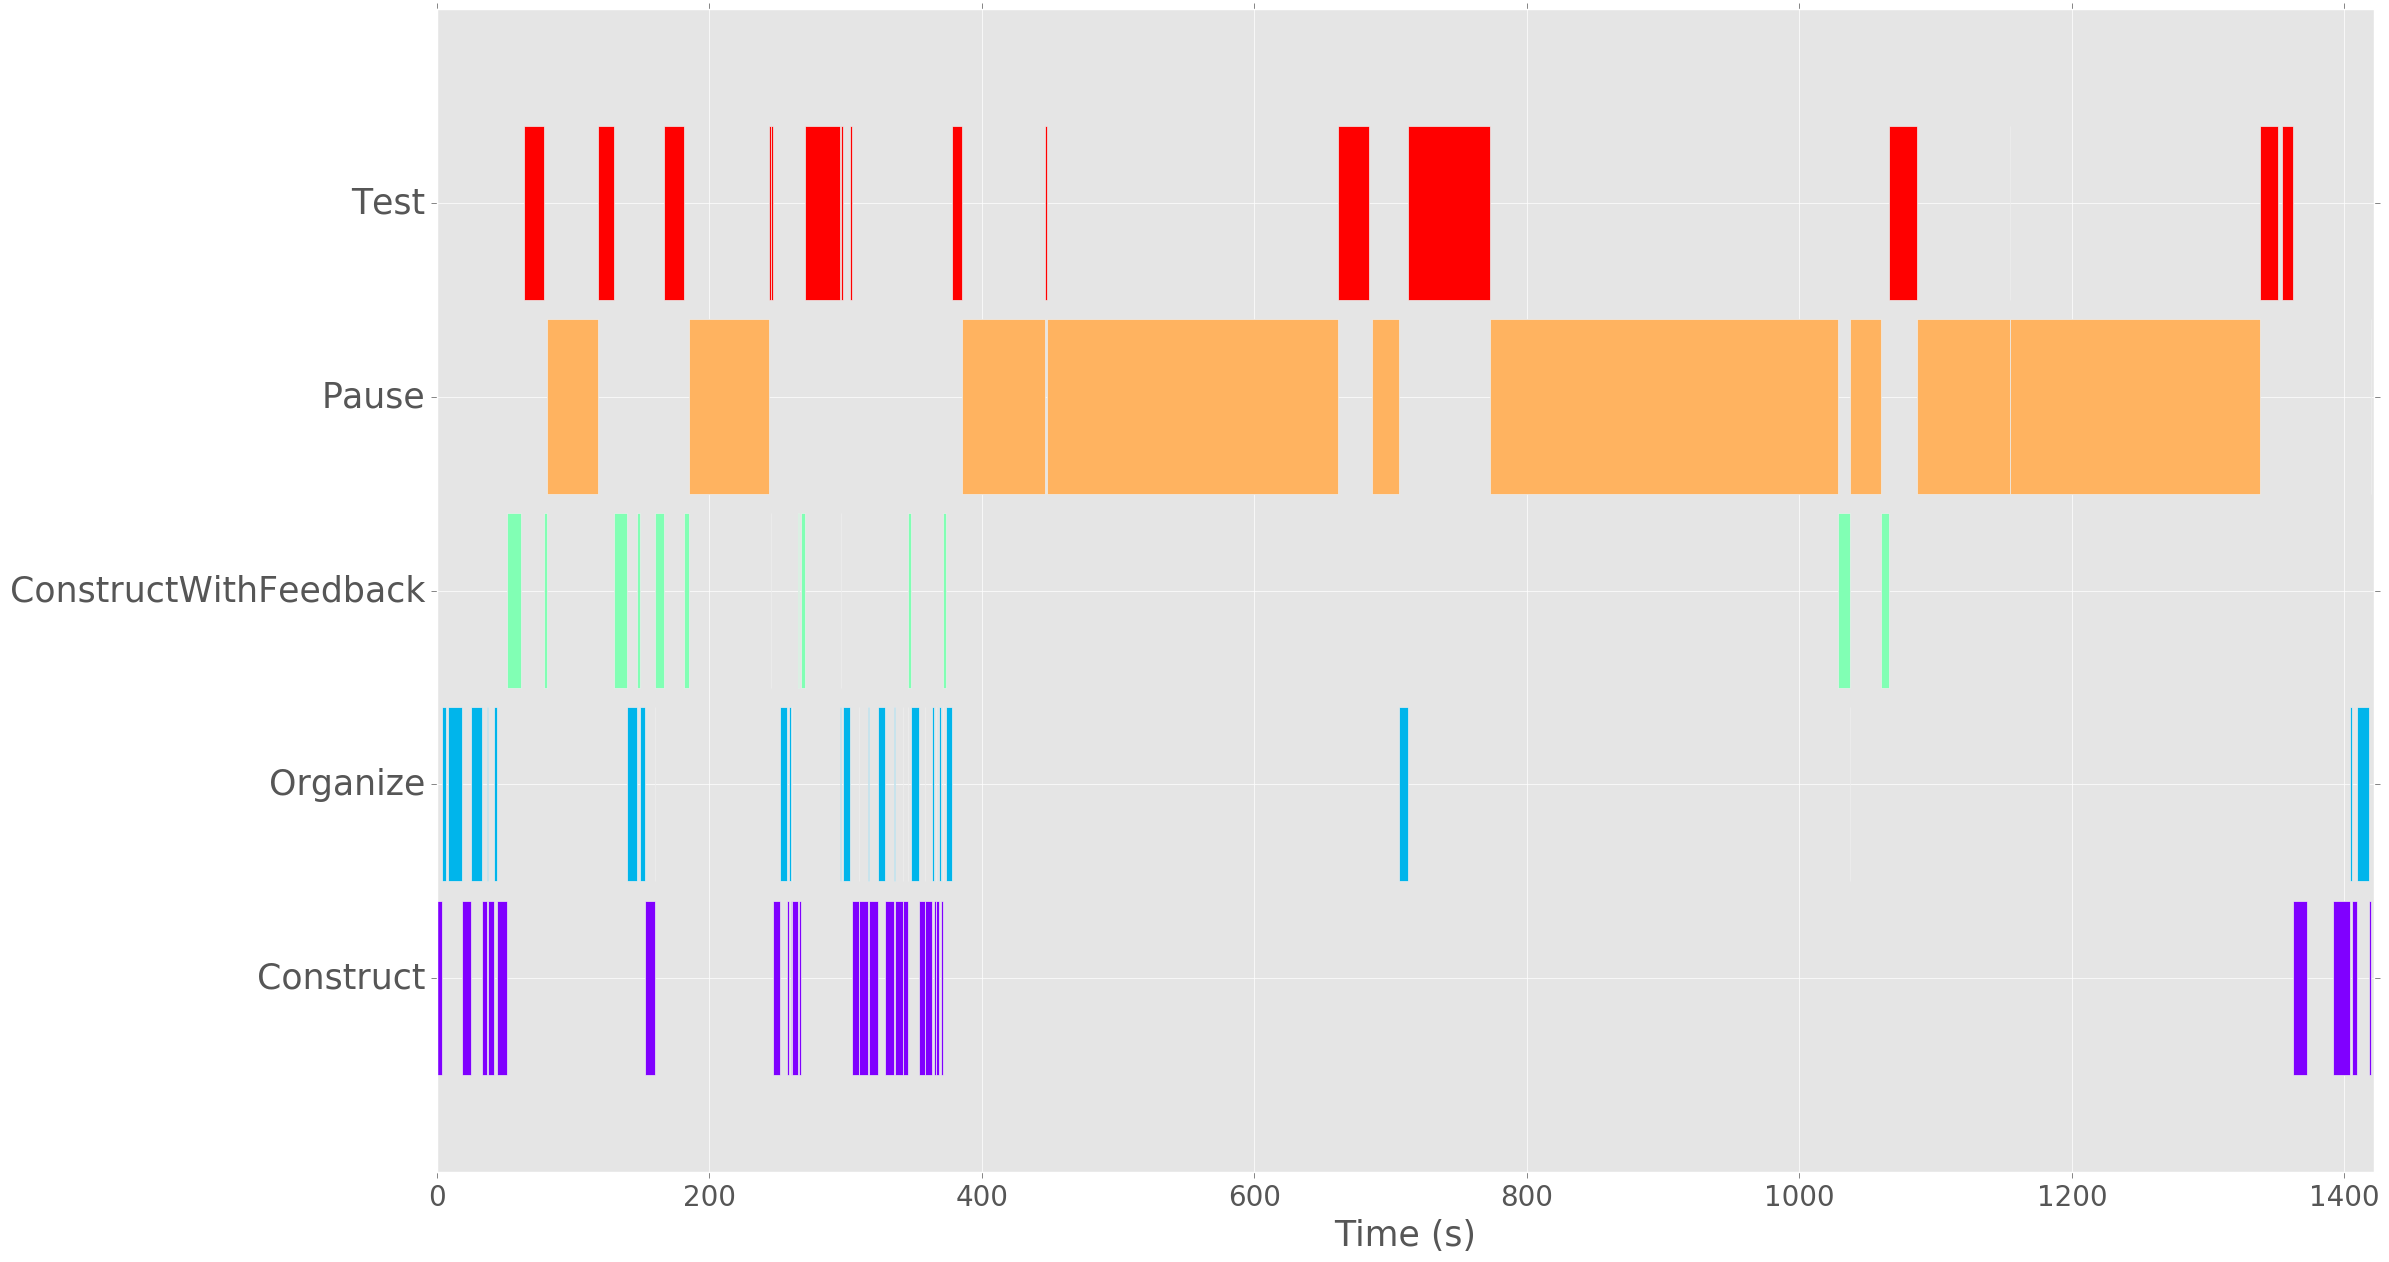

In [15]:
plot_barGraph(df,'a2', 86170104, pltFamilies)  

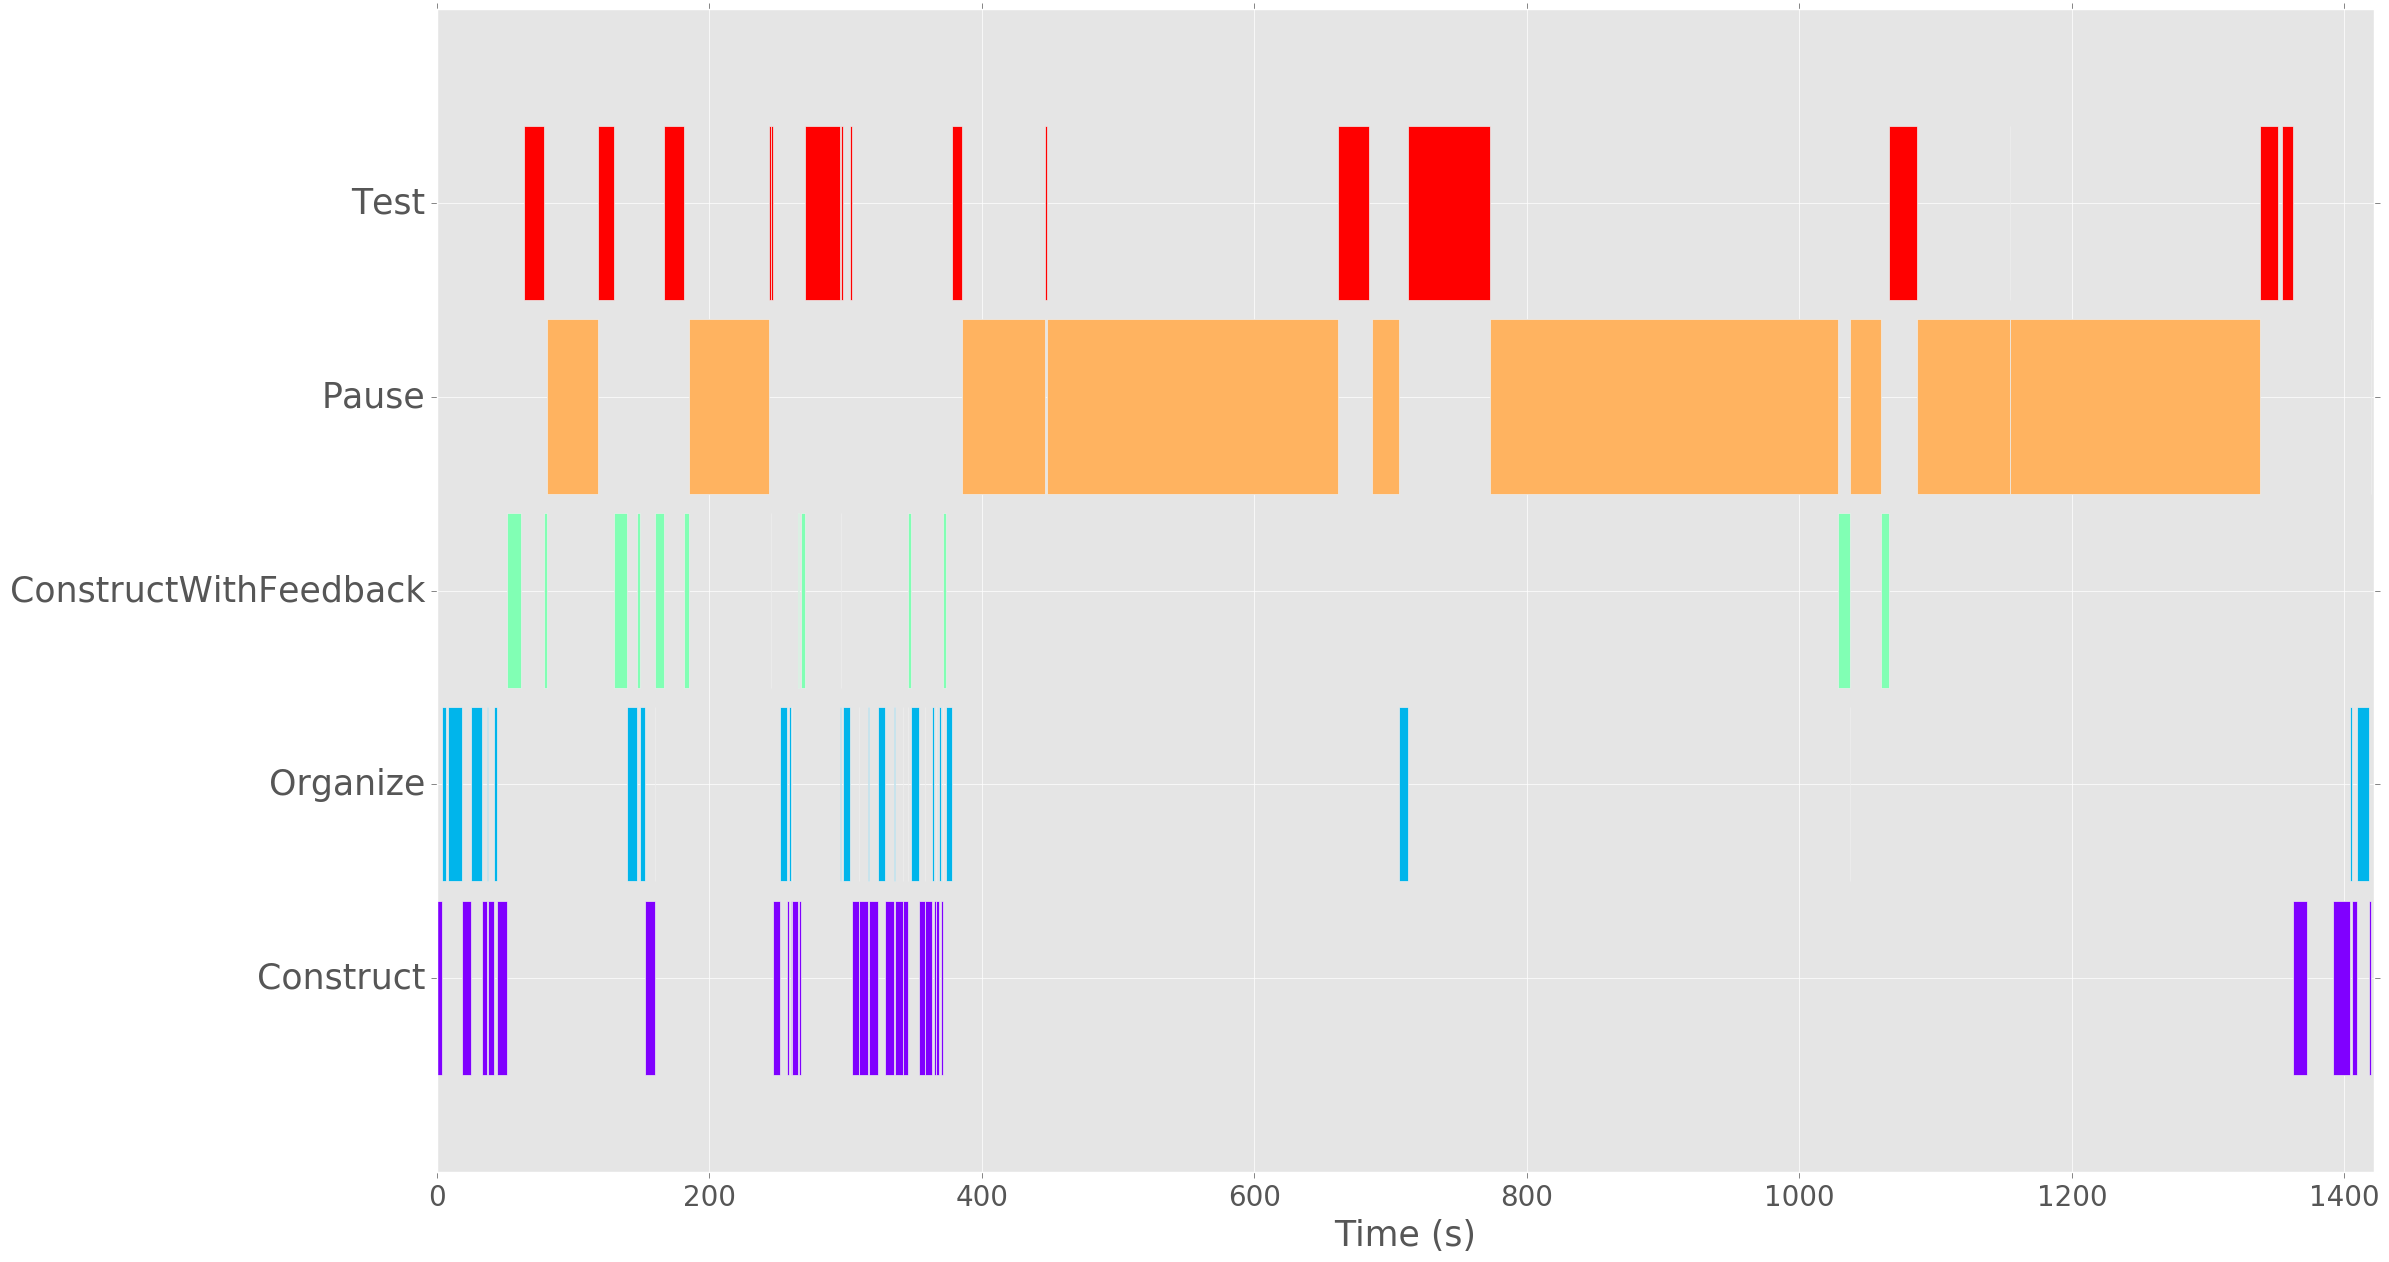

In [16]:
plot_barGraph(df,'a2', 86170104, pltFamilies)  

In [17]:
df_scores[df_scores["student"]==1075123]  #high learning gains (low to high z-scores)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
0,March,scaff,2,2,0,0,1,1,1,0,0,0.21,-0.42,0.64,0.79,0.75,-1.52,-0.42,0.33,2.67,2.78,2.67,4.0,3.5,attitude,scaffolded_attitude,1075123,1920143974,1.85,2.05


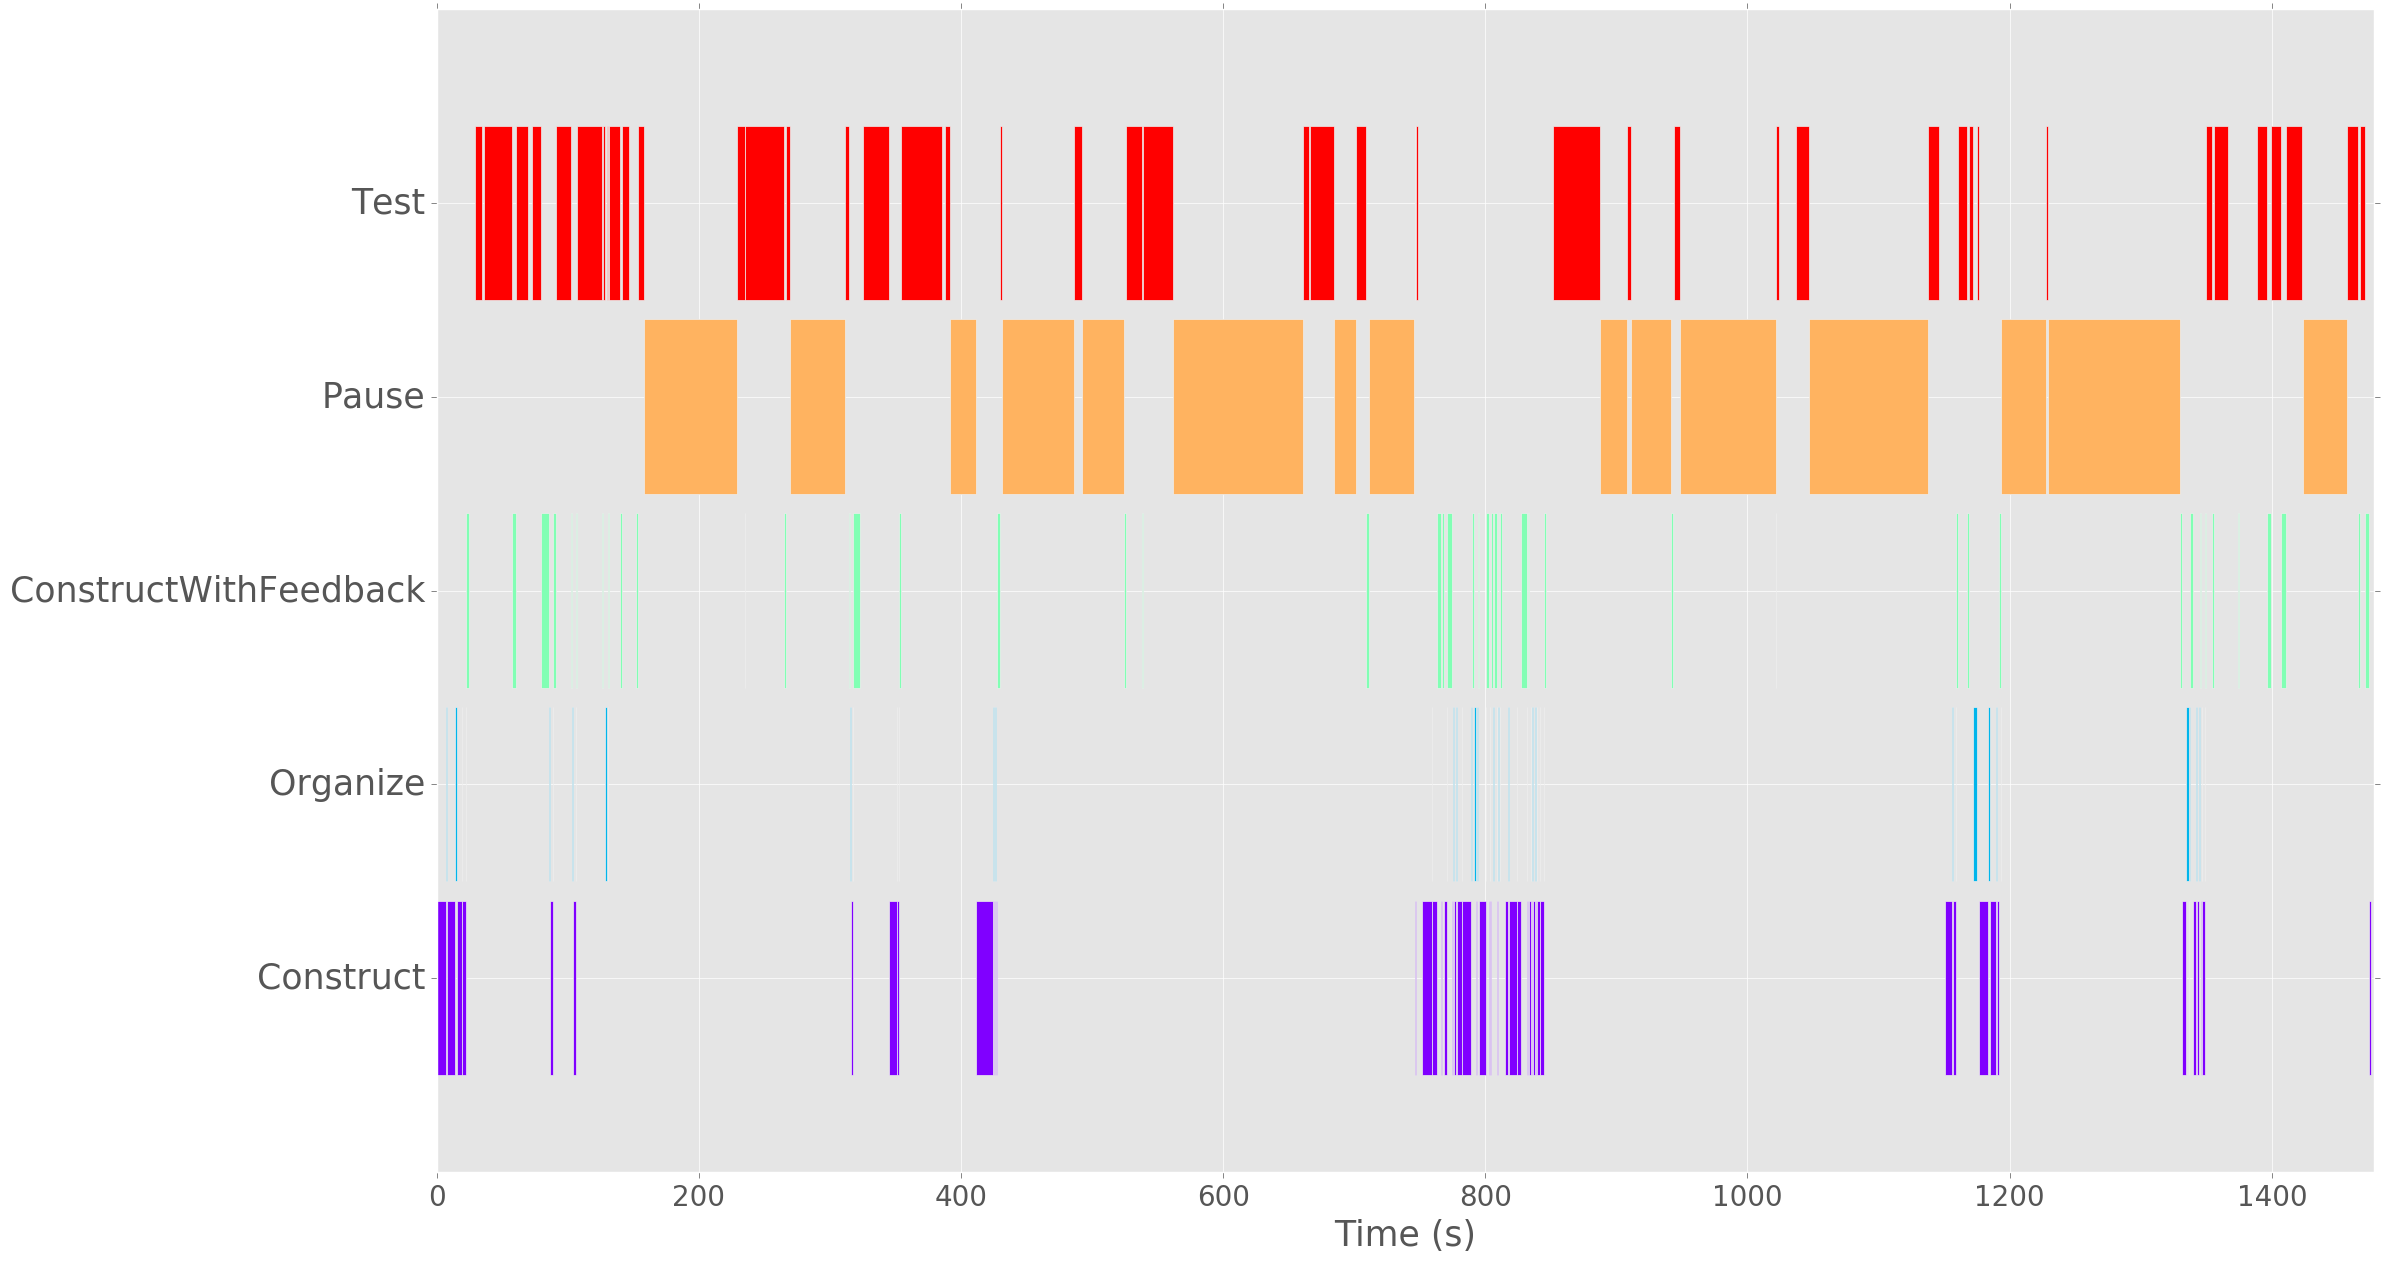

In [18]:
plot_barGraph(df,'a2', 1075123, pltFamilies)  #another low to high z-scores

### High to low scores

In [19]:
df_scores[df_scores["student"]==31091114]  #high learning gains (low to high z-scores)

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
32,July,not,3,2,1,1,0,1,1,1,1,0.75,0.73,0.38,0.5,-0.52,1.64,0.73,-1.07,2.44,1.89,2.78,4.0,2.25,knowledge,notscaffolded_knowledge,31091114,-1447878640,-2.71,-0.49


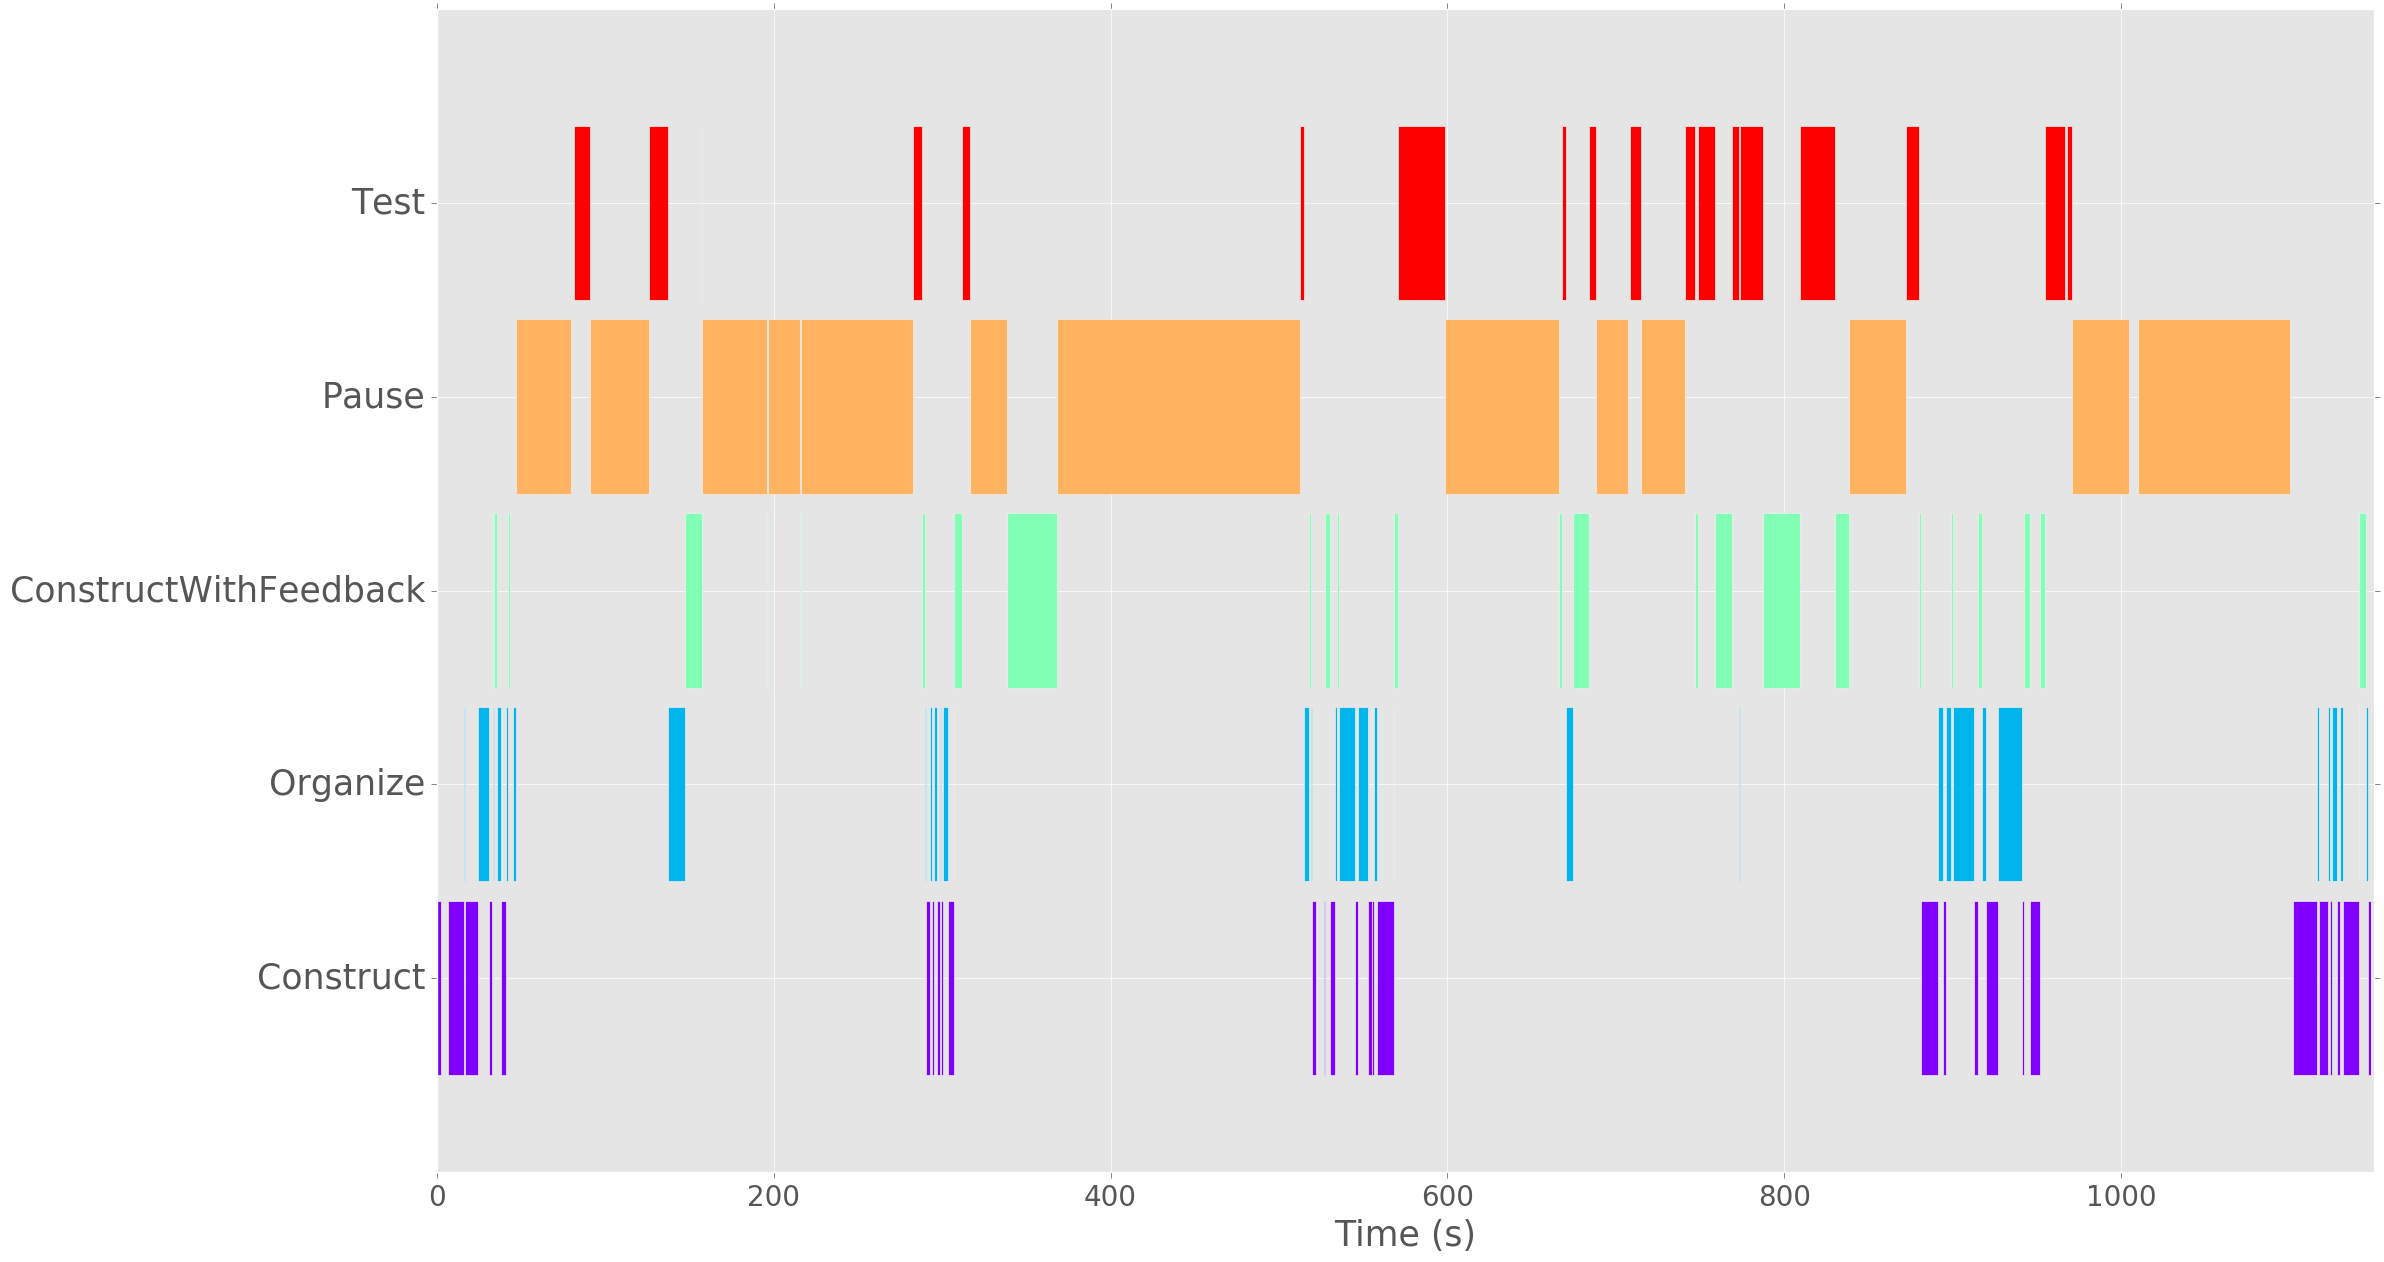

In [20]:
plot_barGraph(df,'a2',31091114, pltFamilies) #high low z-scores

In [21]:
df_scores[df_scores["student"]==13205111]

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
13,July,scaff,1,2,0,0,0,1,1,2,1,0.75,1.56,0.55,0.38,-1.07,1.64,1.56,-0.14,2.89,2.89,3.0,4.0,3.25,knowledge,scaffolded_knowledge,13205111,1170221006,-1.78,-0.27


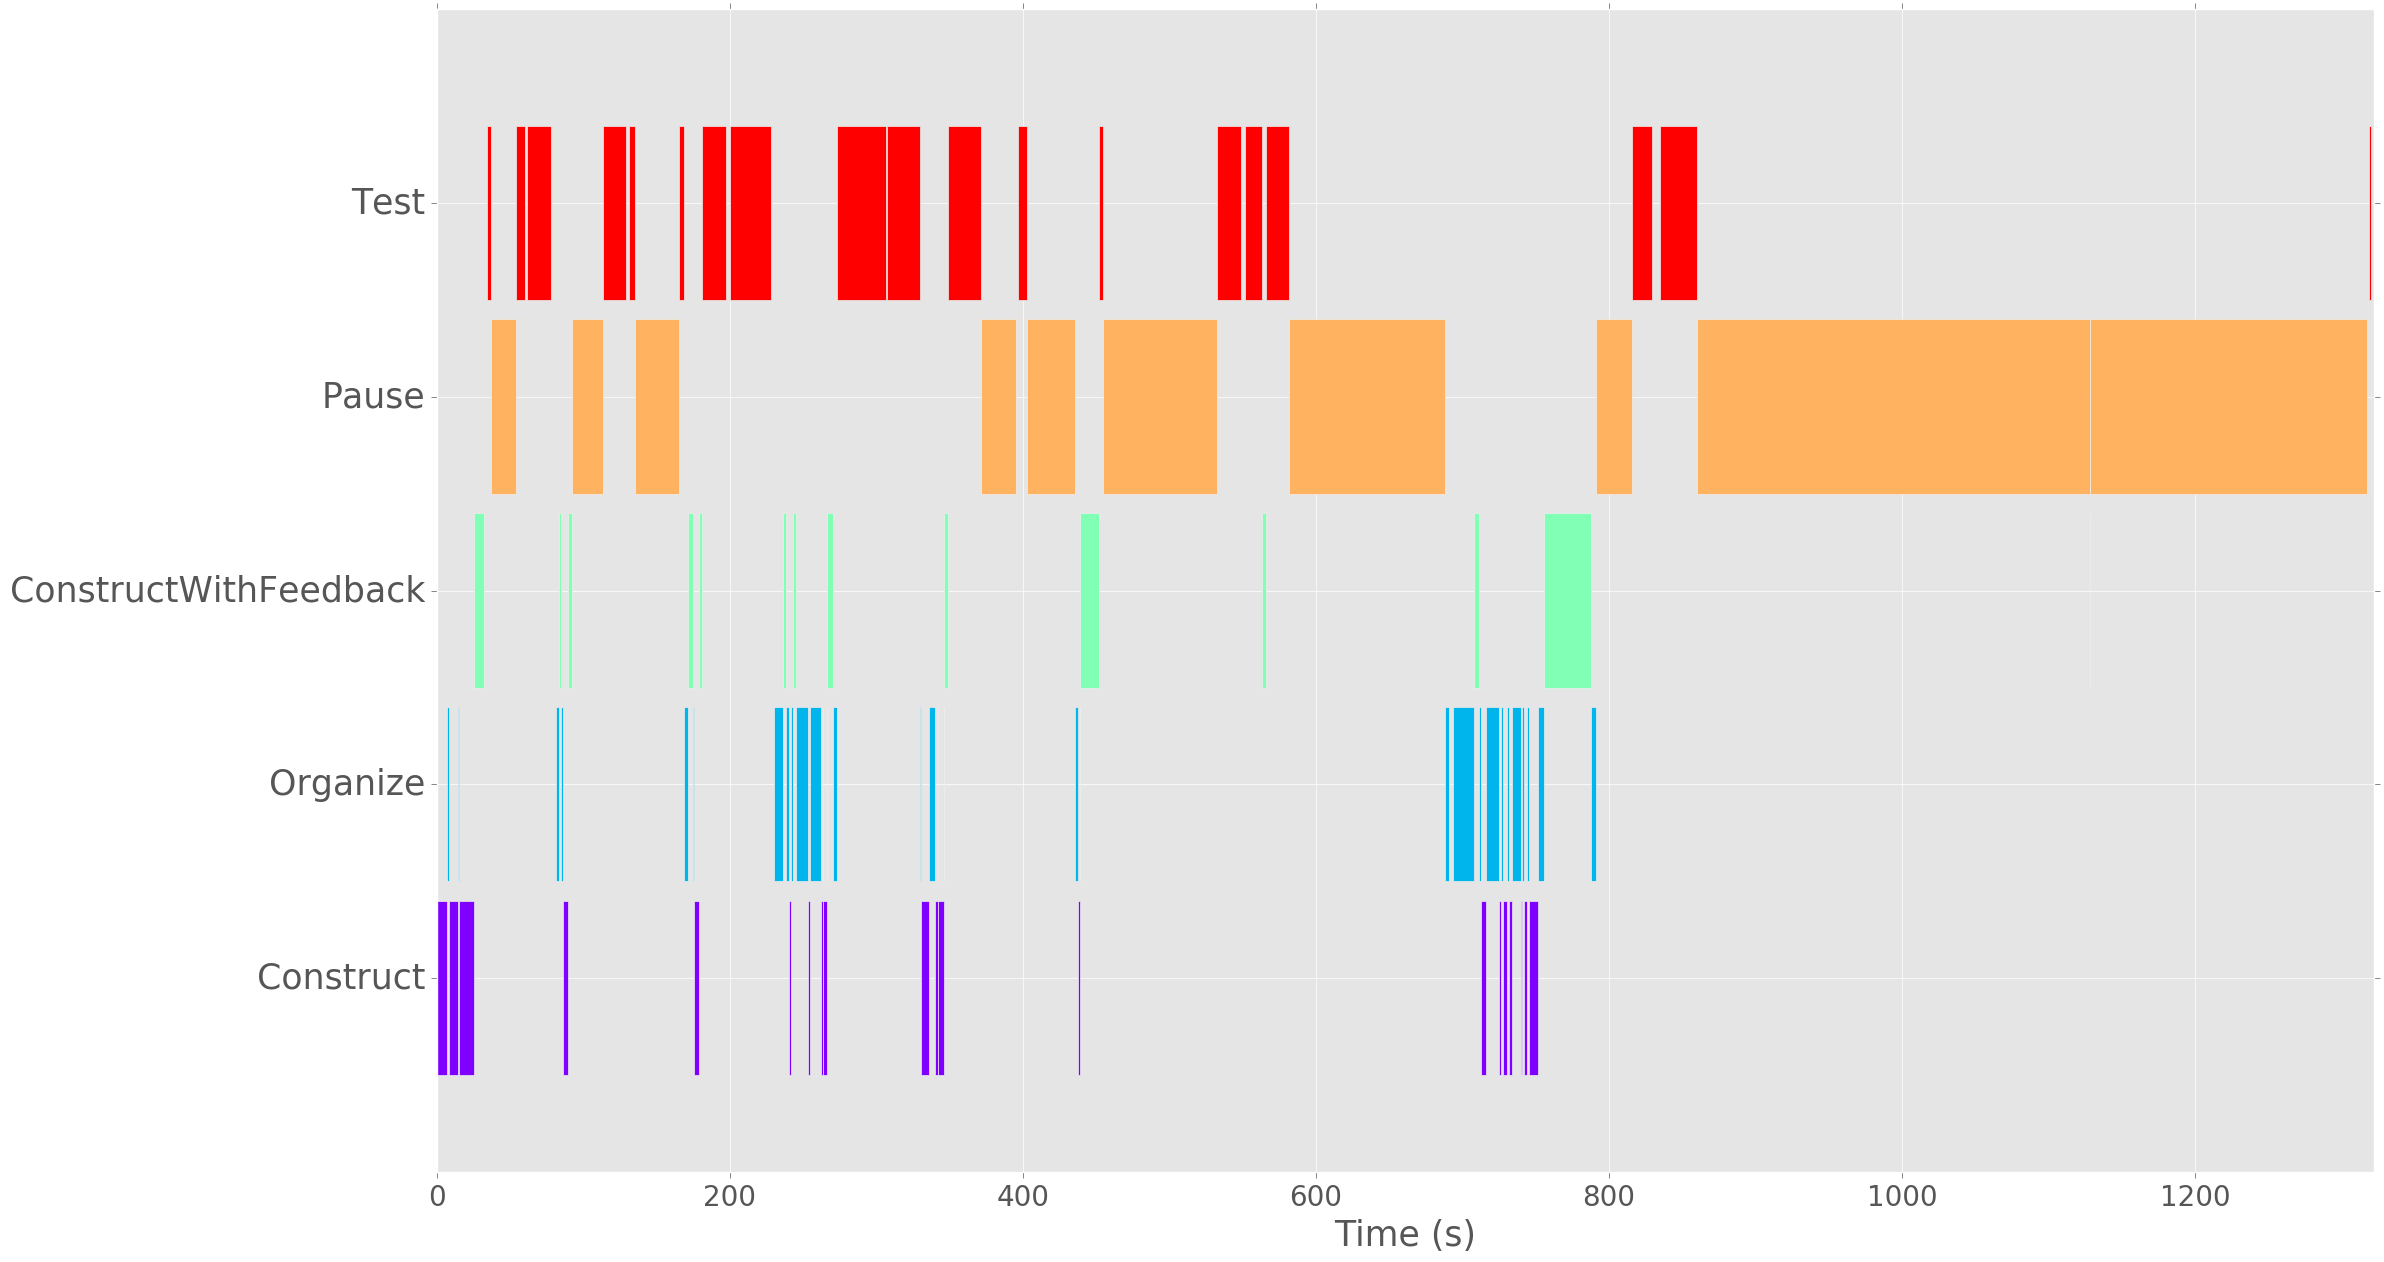

In [22]:
plot_barGraph(df,'a2',13205111, pltFamilies) #high low z-scores

### Low to low scores

In [23]:
df_scores[df_scores["student"]==8889108]

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
7,July,scaff,1,3,0,0,1,1,1,0,0,0.21,-0.72,0.27,0.21,-1.79,-1.52,-0.72,-1.62,2.67,2.33,2.33,2.0,3.25,attitude,scaffolded_attitude,8889108,1140619053,-0.1,0.29


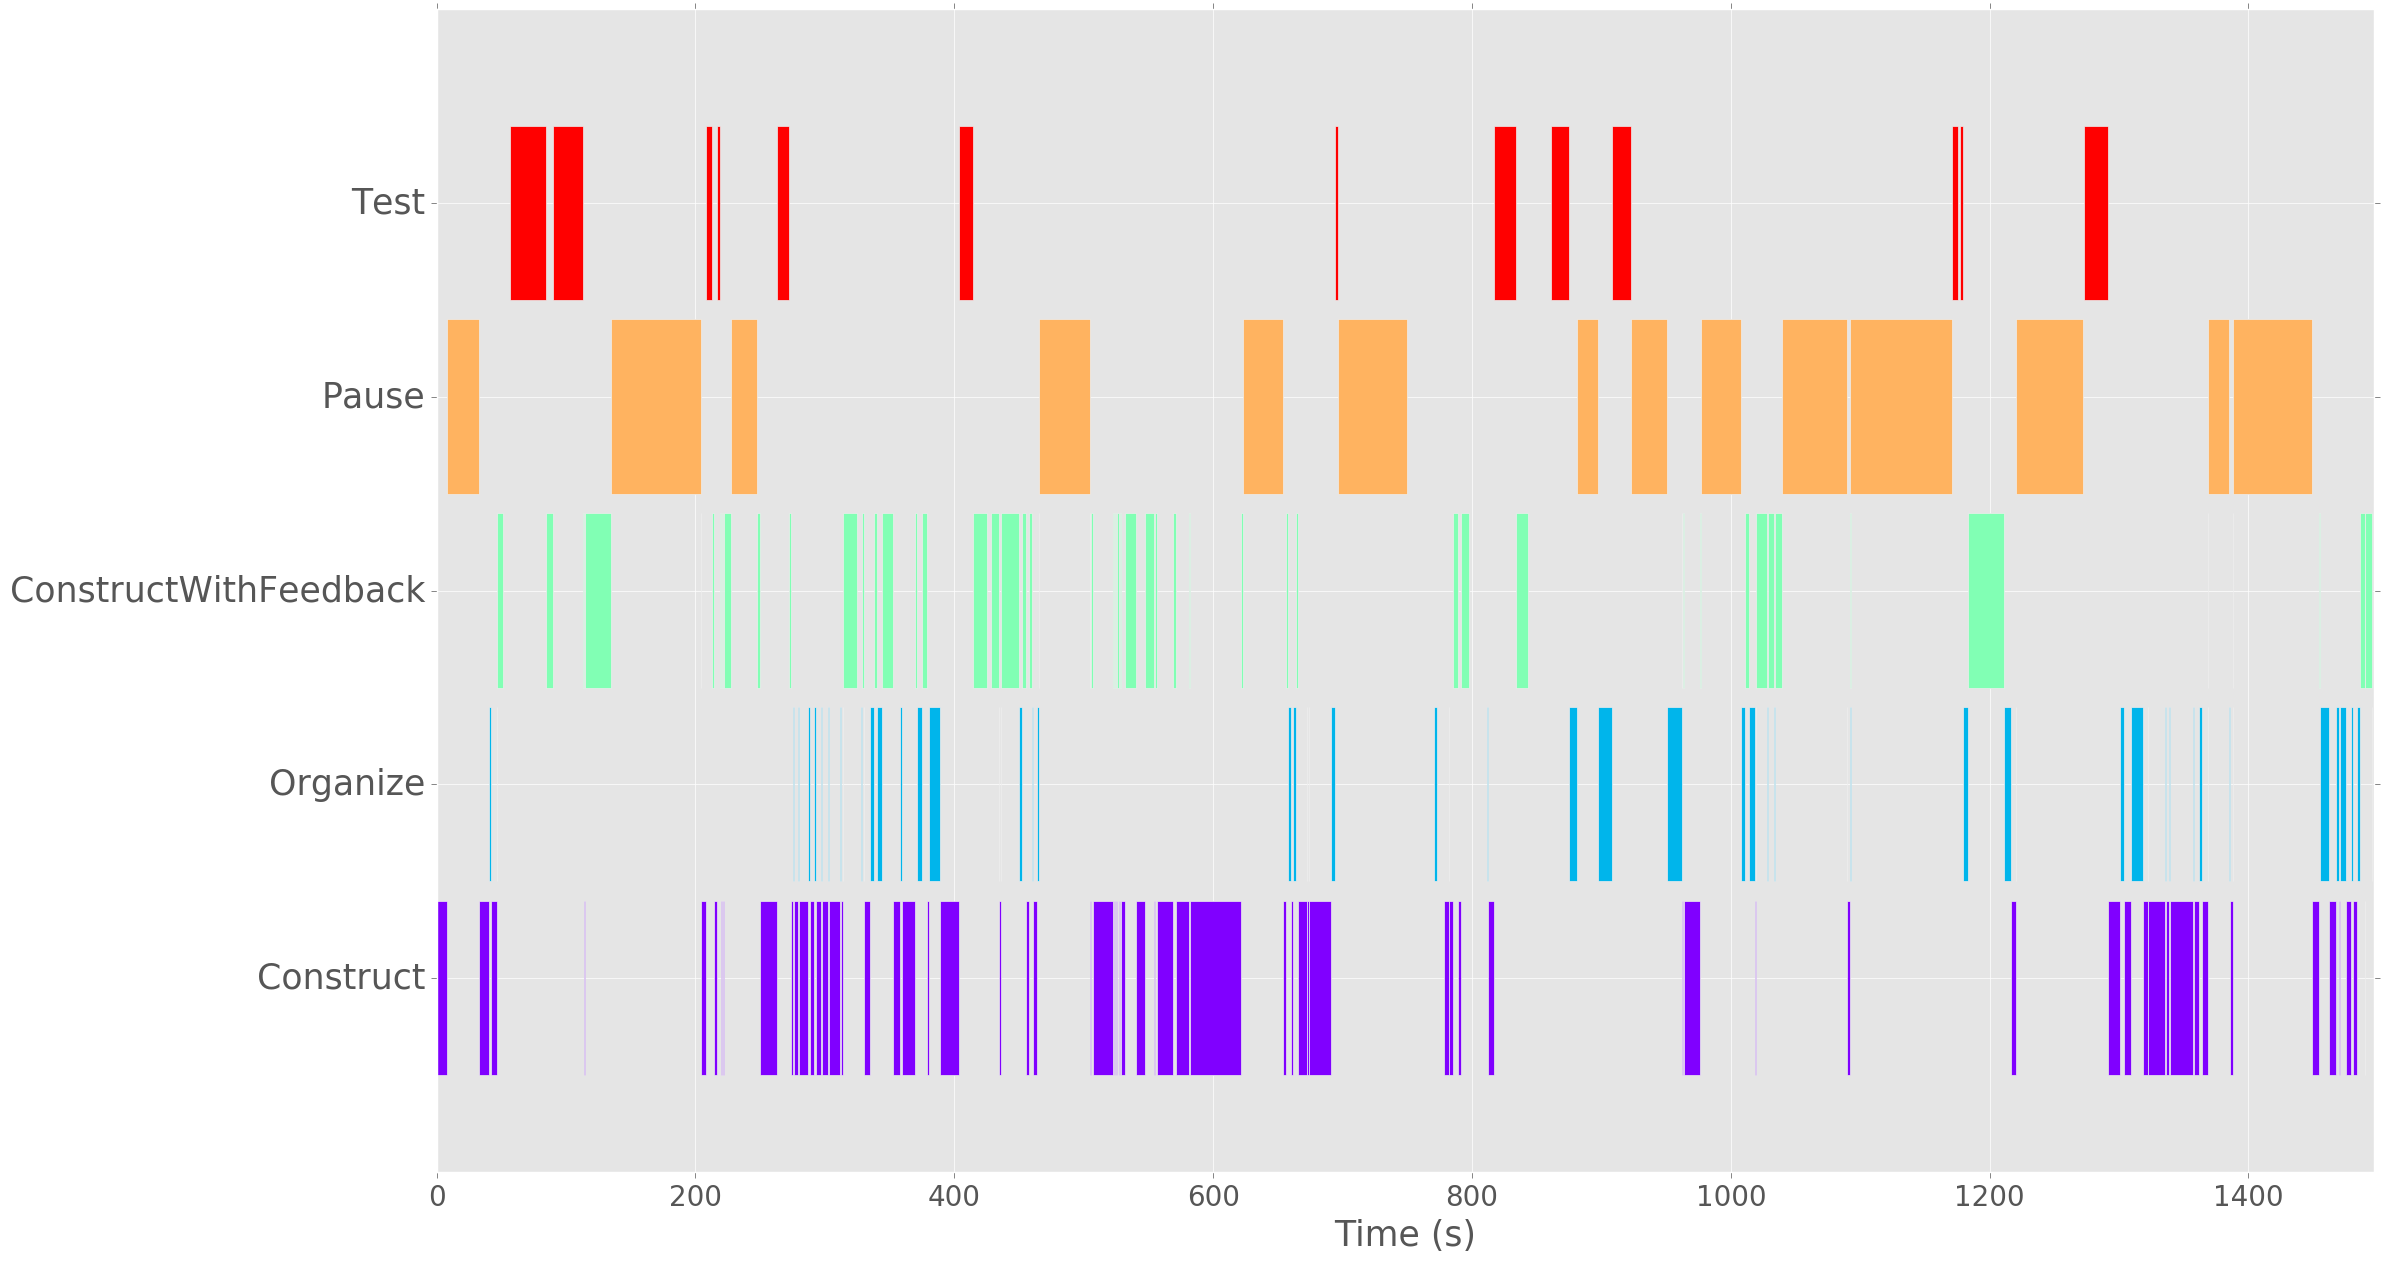

In [24]:
plot_barGraph(df,'a2',8889108, pltFamilies) #low low z-scores

In [25]:
df_scores[df_scores["student"]==19930112]

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
23,July,not,2,2,1,0,1,0,1,0,0,0.25,0.11,0.35,0.71,0.38,-1.27,0.11,-1.18,3.0,3.11,3.0,5.0,3.25,attitude,notscaffolded_attitude,19930112,1049426630,0.09,0.4


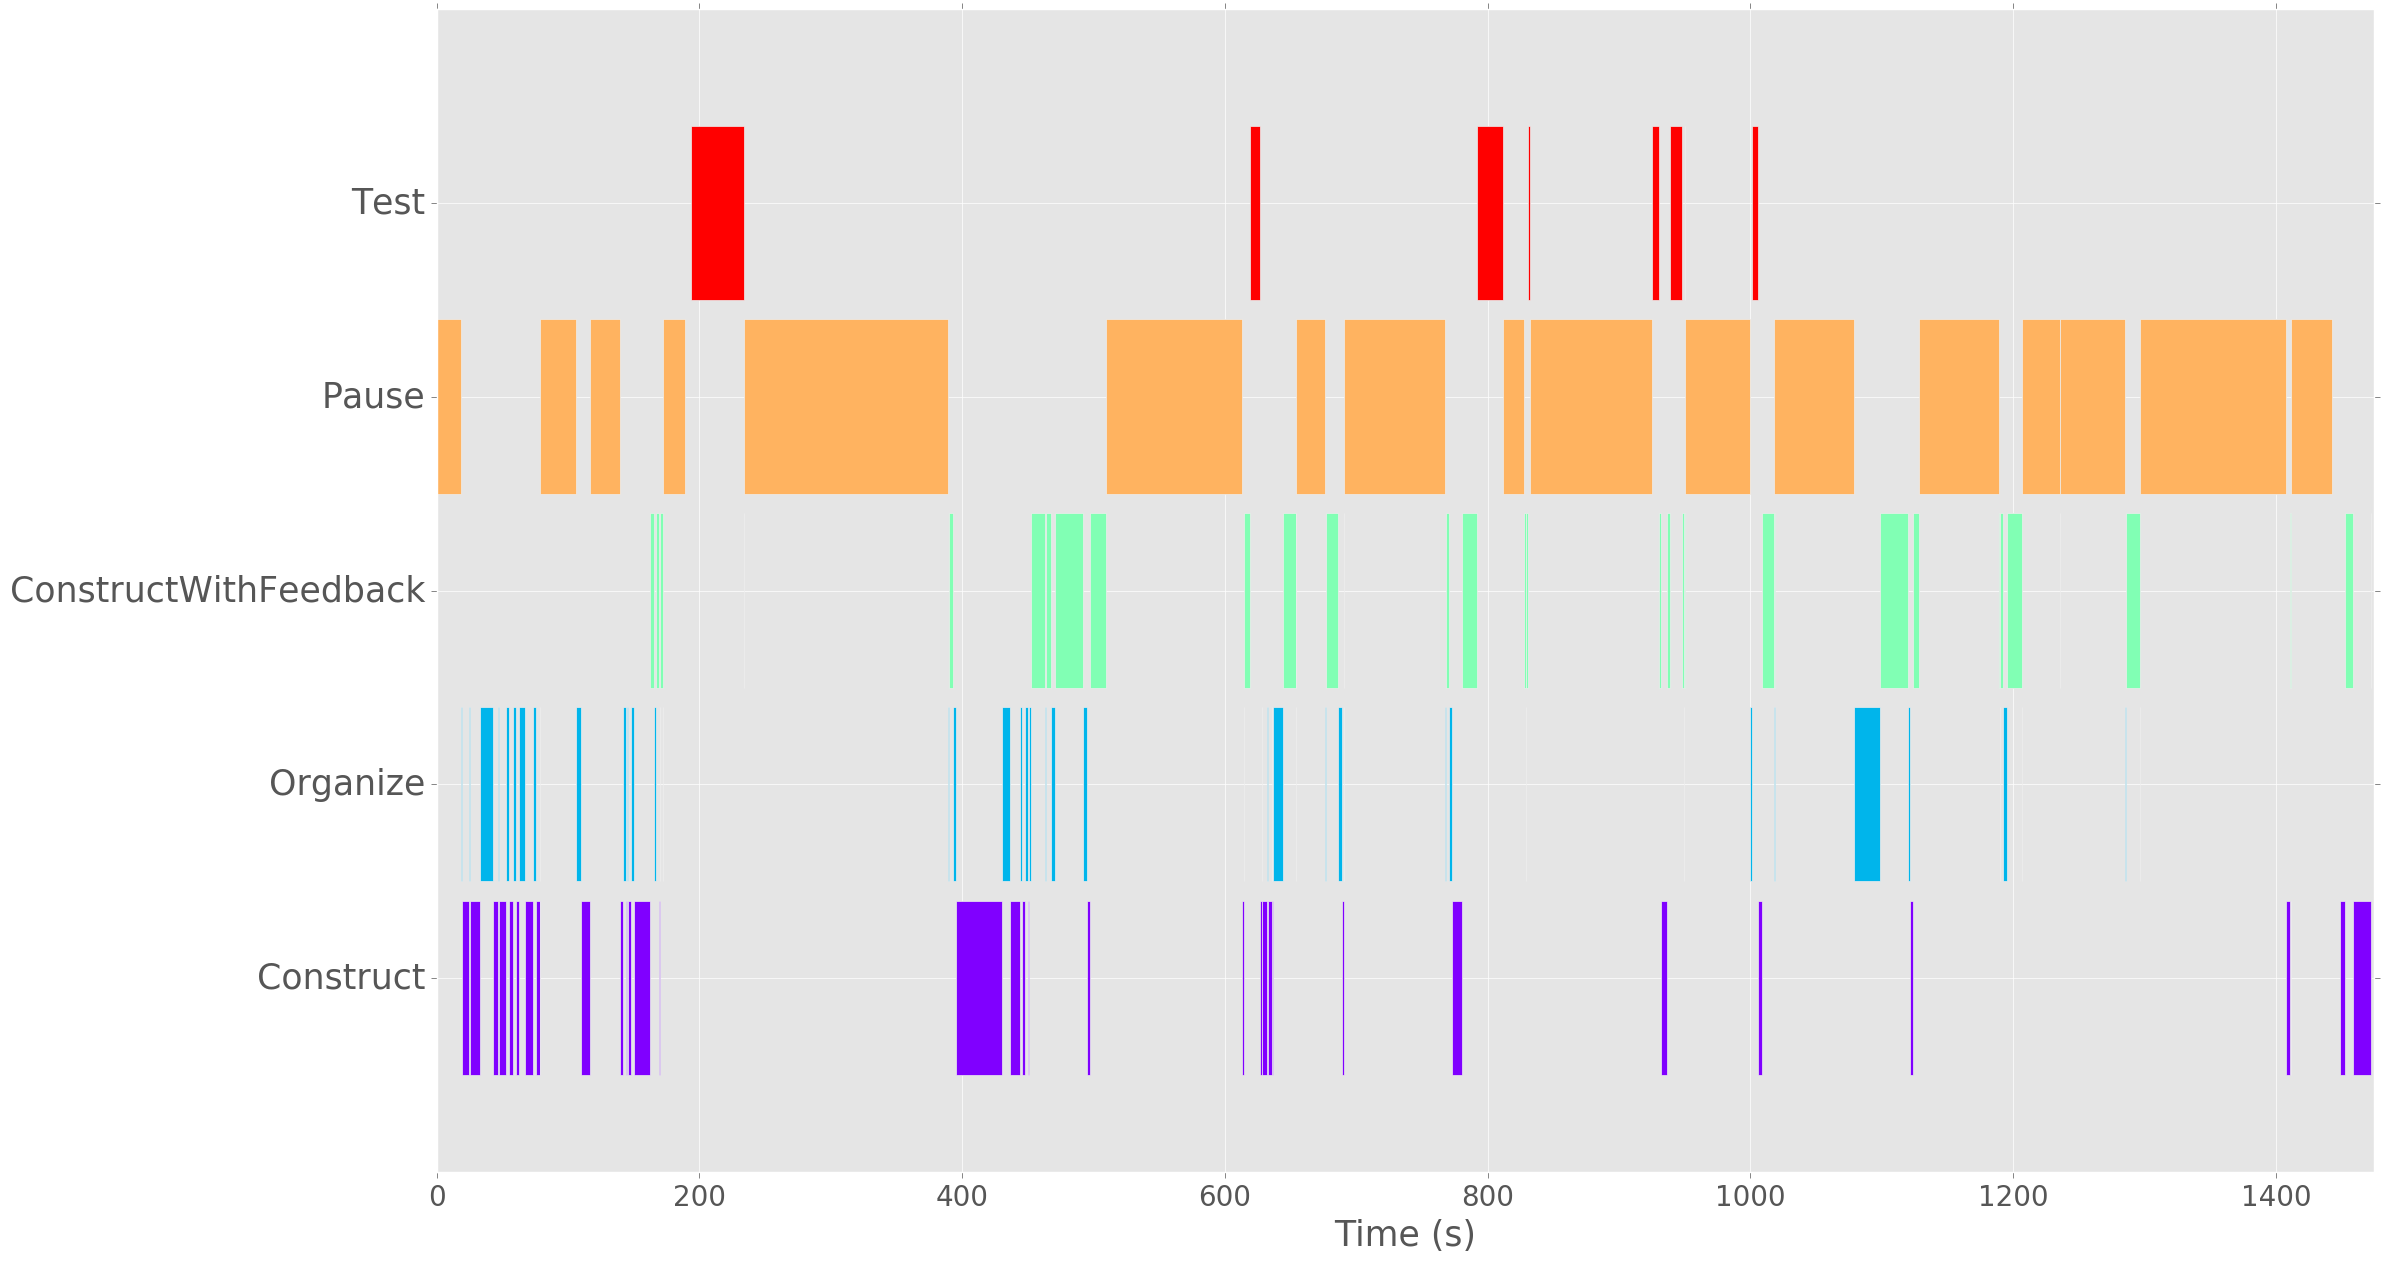

In [26]:
plot_barGraph(df,'a2',19930112, pltFamilies) #low low z-scores

### High to high scores

In [27]:
df_scores[df_scores["student"]==8580120]

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
5,March,scaff,2,3,0,1,1,1,1,0,0,0.75,0.58,0.91,1.0,1.65,1.64,0.58,1.79,2.78,2.78,2.89,4.0,3.0,knowledge,scaffolded_knowledge,8580120,1682116183,0.15,0.21


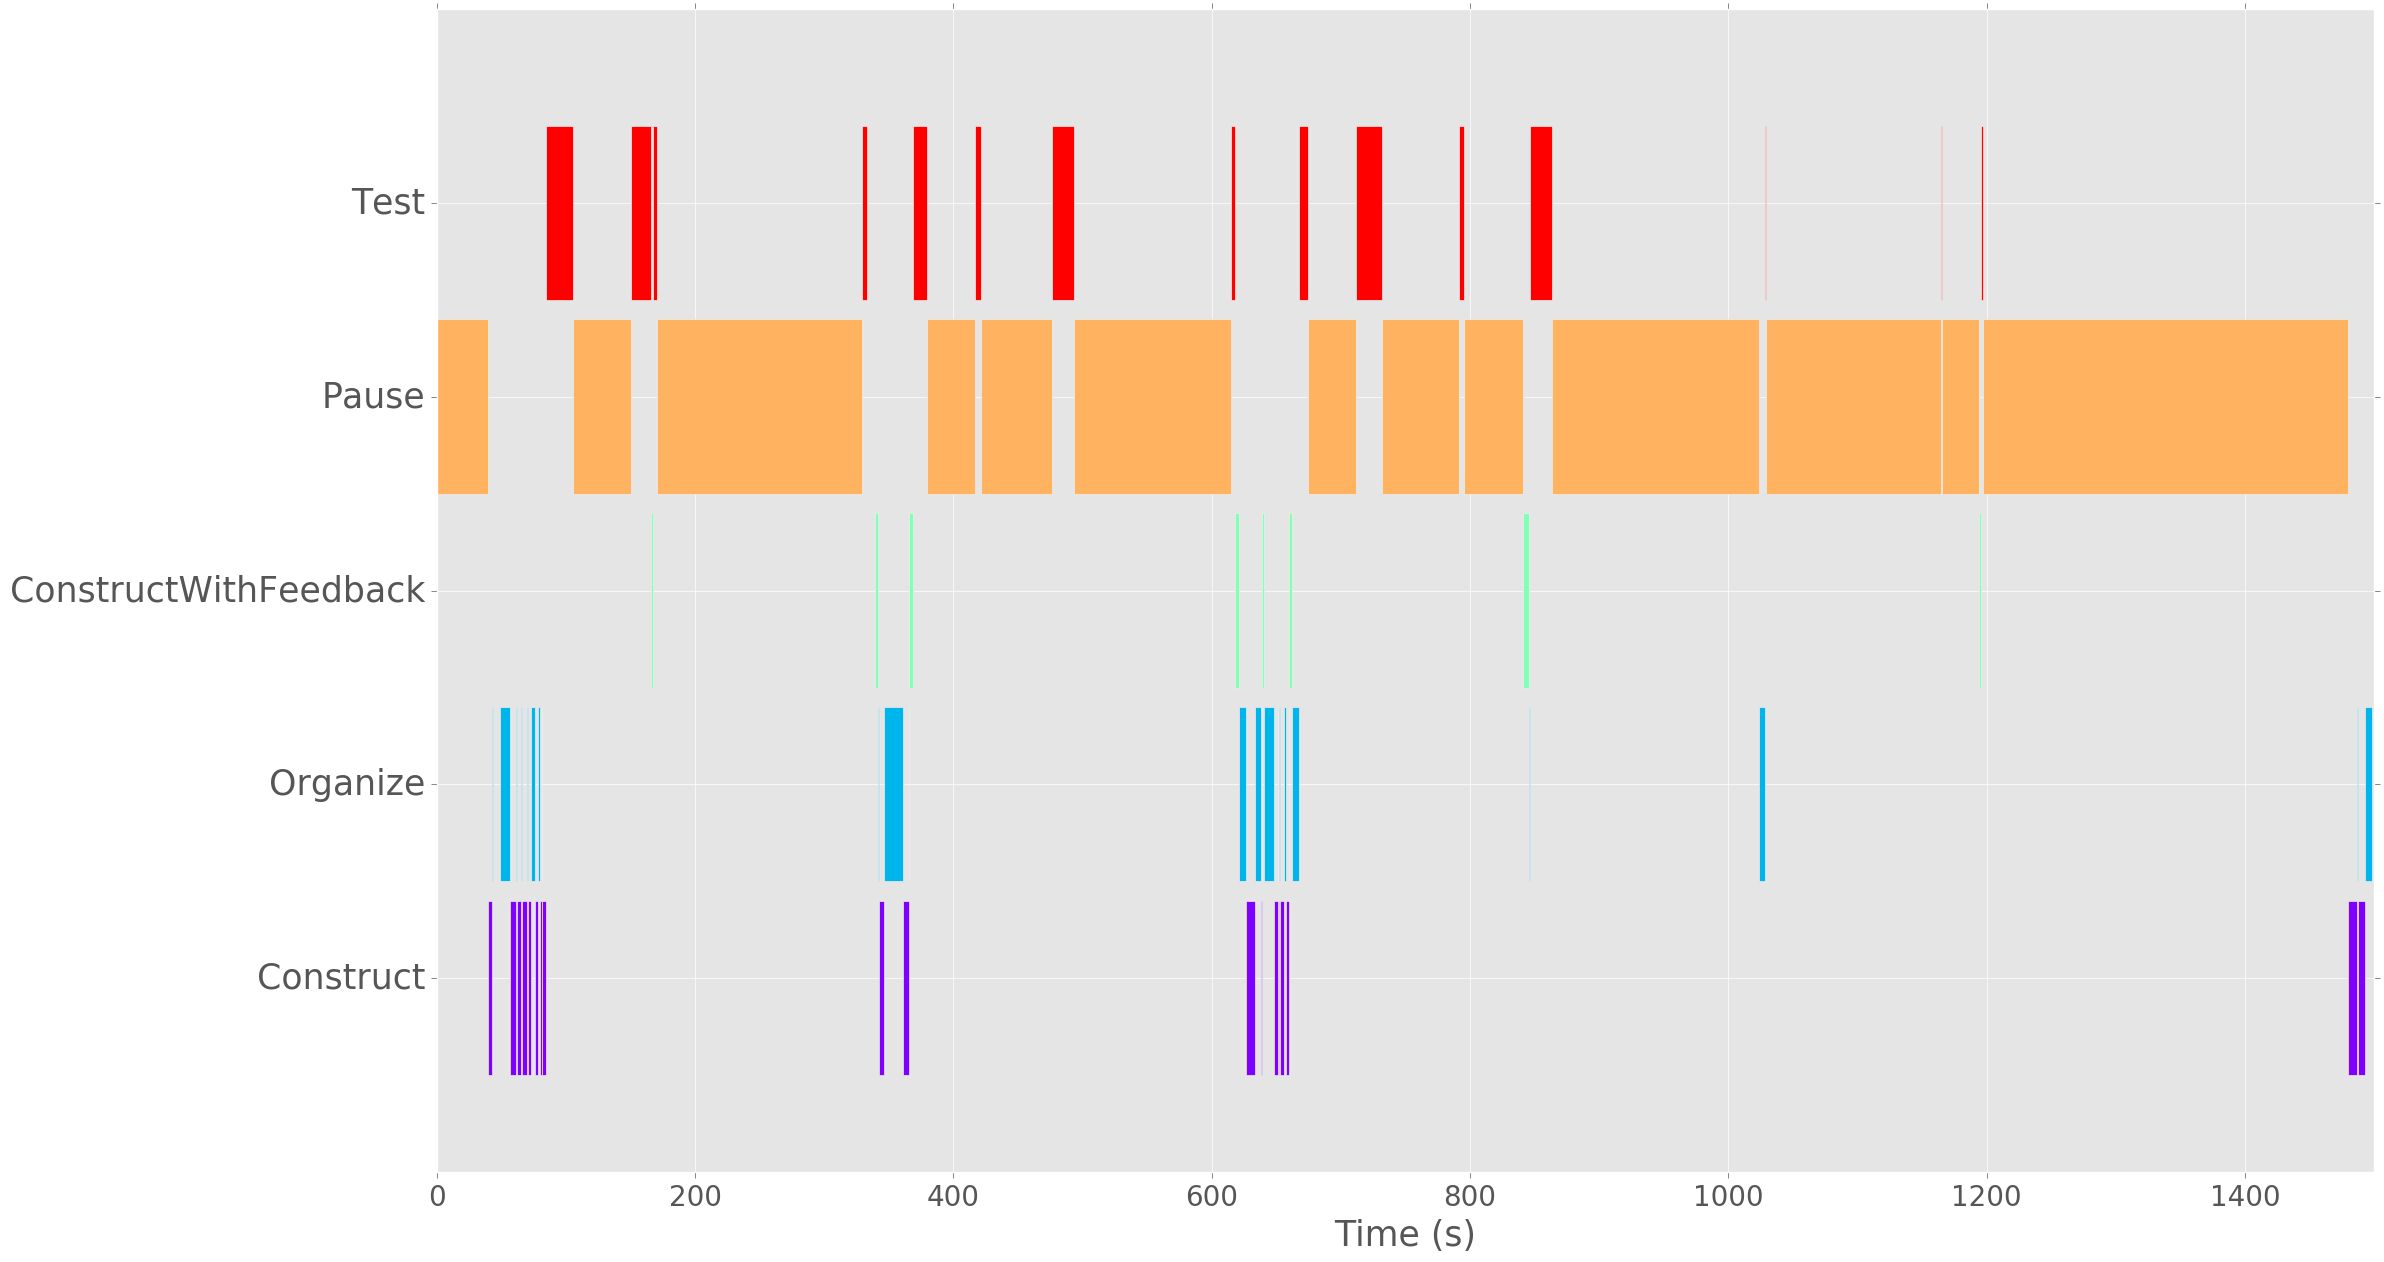

In [28]:
plot_barGraph(df,'a2',8580120, pltFamilies) #high high z-scores

In [29]:
df_scores[df_scores["student"]==18838125]

,Wave,scaffolding,how many PhETs in the past?,how comfortable with phets?,p100,used this circuit sim before?,COMPLETEDNESS,PRIORKNOWLEDGE,COMPLEXITY,DIAGRAMS,NUMBERSANDCALCULATIONSONLYINATLEASTONEANSWER,pre,post t1,post t2,post identical to pre,z post identical to pre,z pre,z post t1,z post t2,T0_PoCC,T1_PoCC,T2_PoCC,Avg_Mast_Or,Perceived Value,Clustergroups,fourgroups,student,Anon Student Id,learning diff a2,learning gains a2
21,July,scaff,3,3,0,1,1,1,1,1,0,0.75,0.53,0.9,1.0,1.65,1.64,0.53,1.72,3.11,2.67,3.33,5.0,3.5,knowledge,scaffolded_knowledge,18838125,-1070897970,0.08,0.2


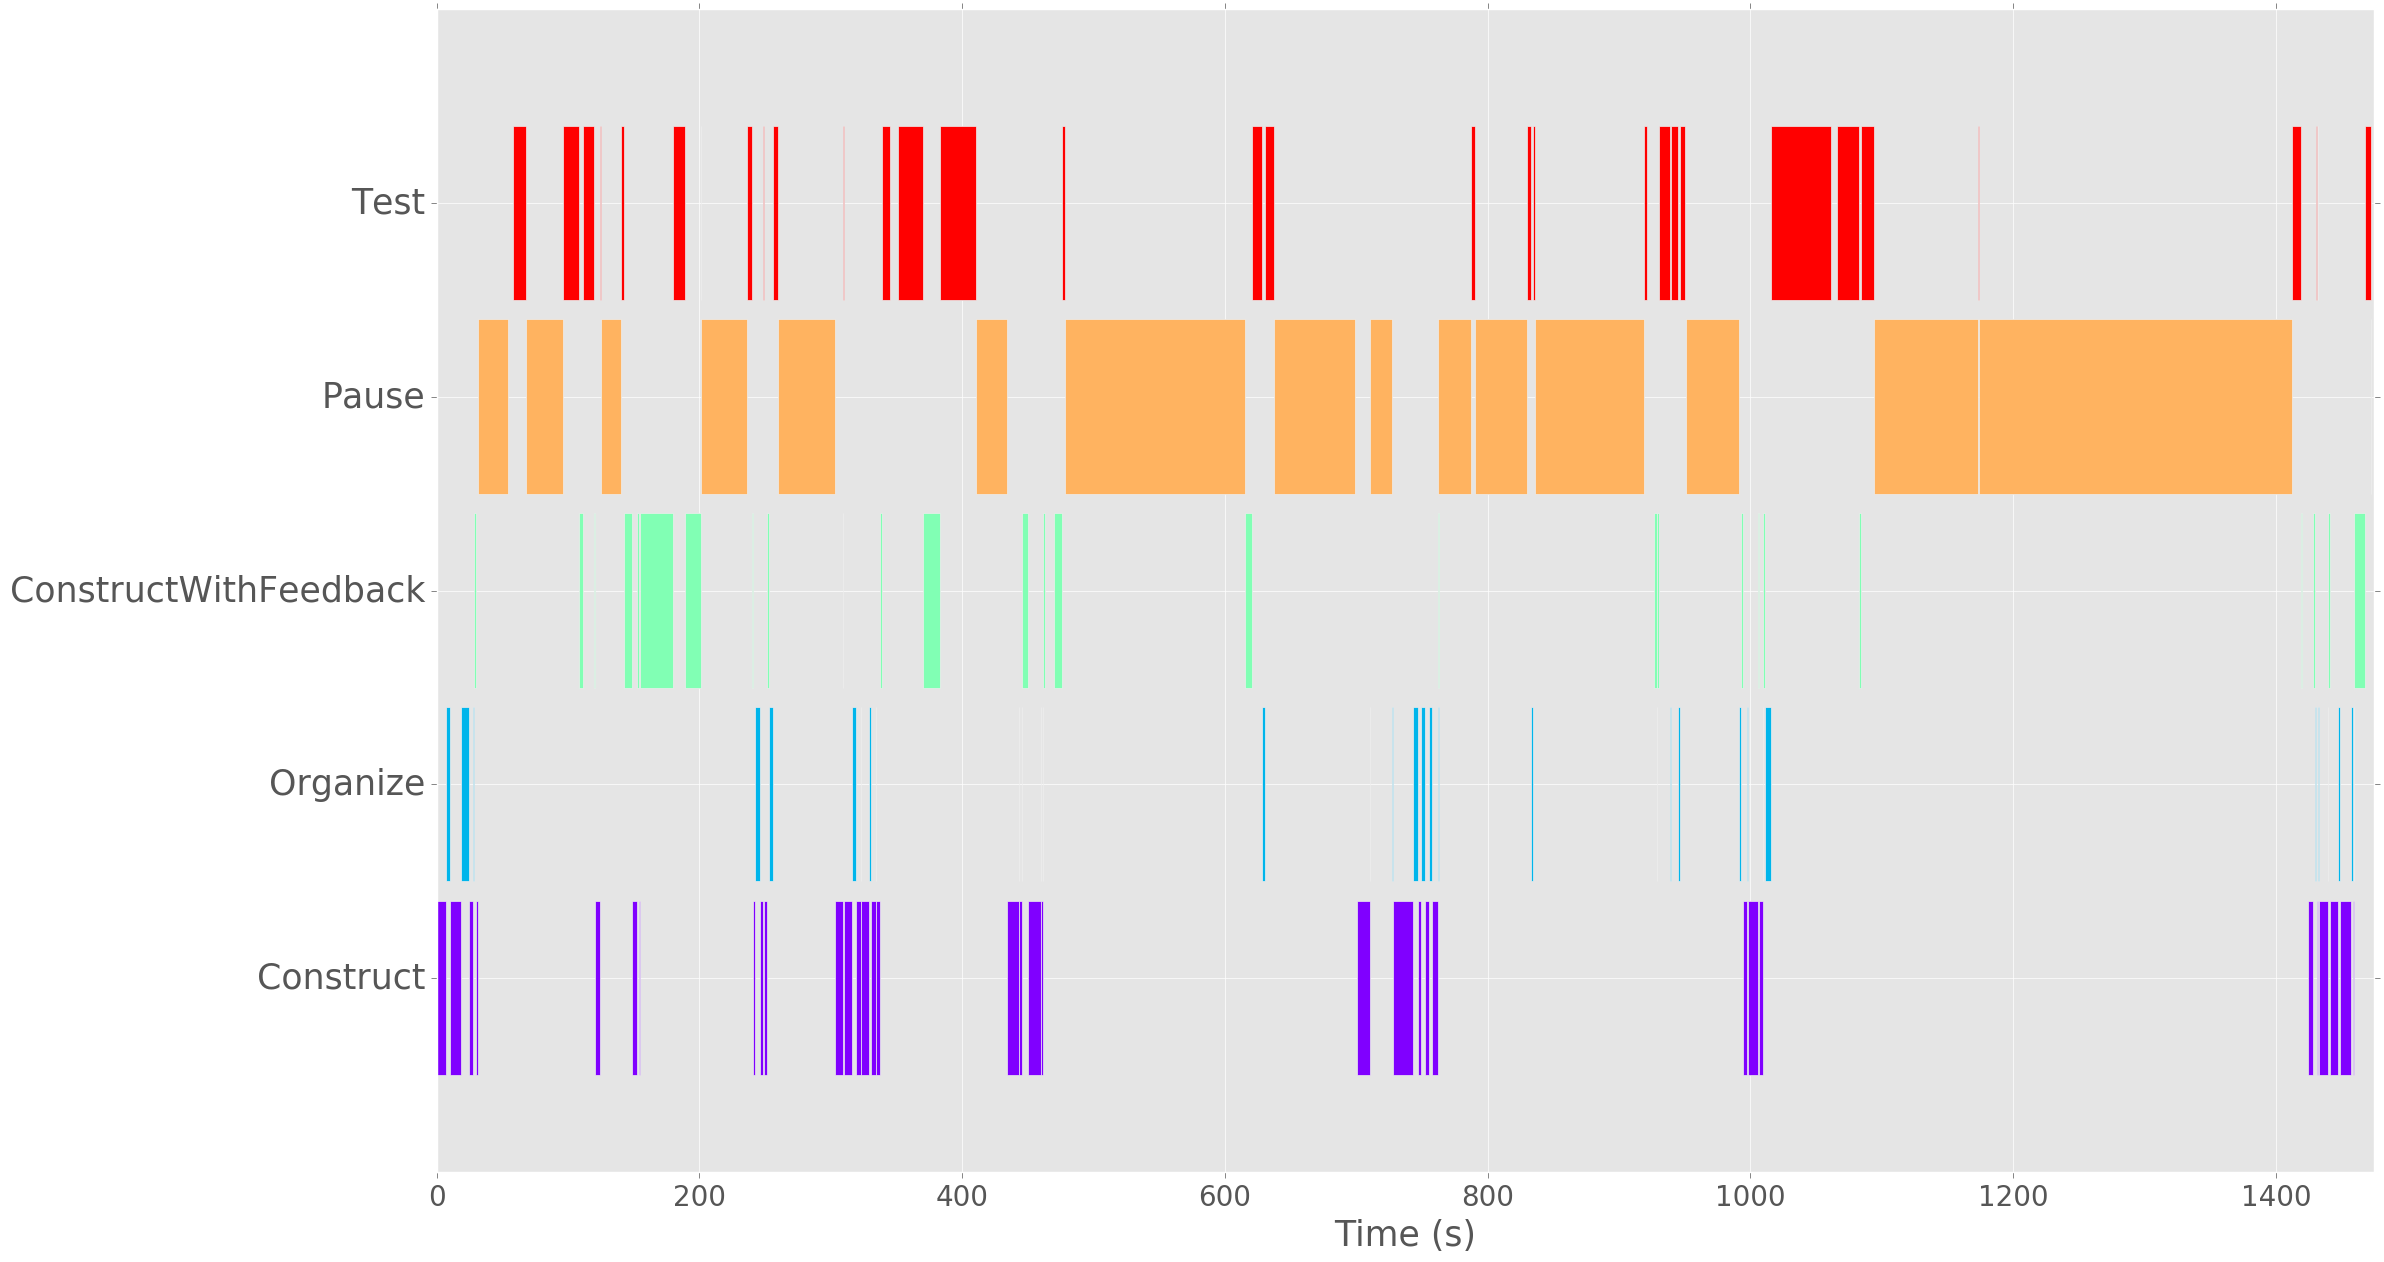

In [30]:
plot_barGraph(df,'a2',18838125, pltFamilies) #high high z-scores

## Plotting fewer action families: Construct = (Construct, ConstructWithFeedback, Organize)

### Low to high

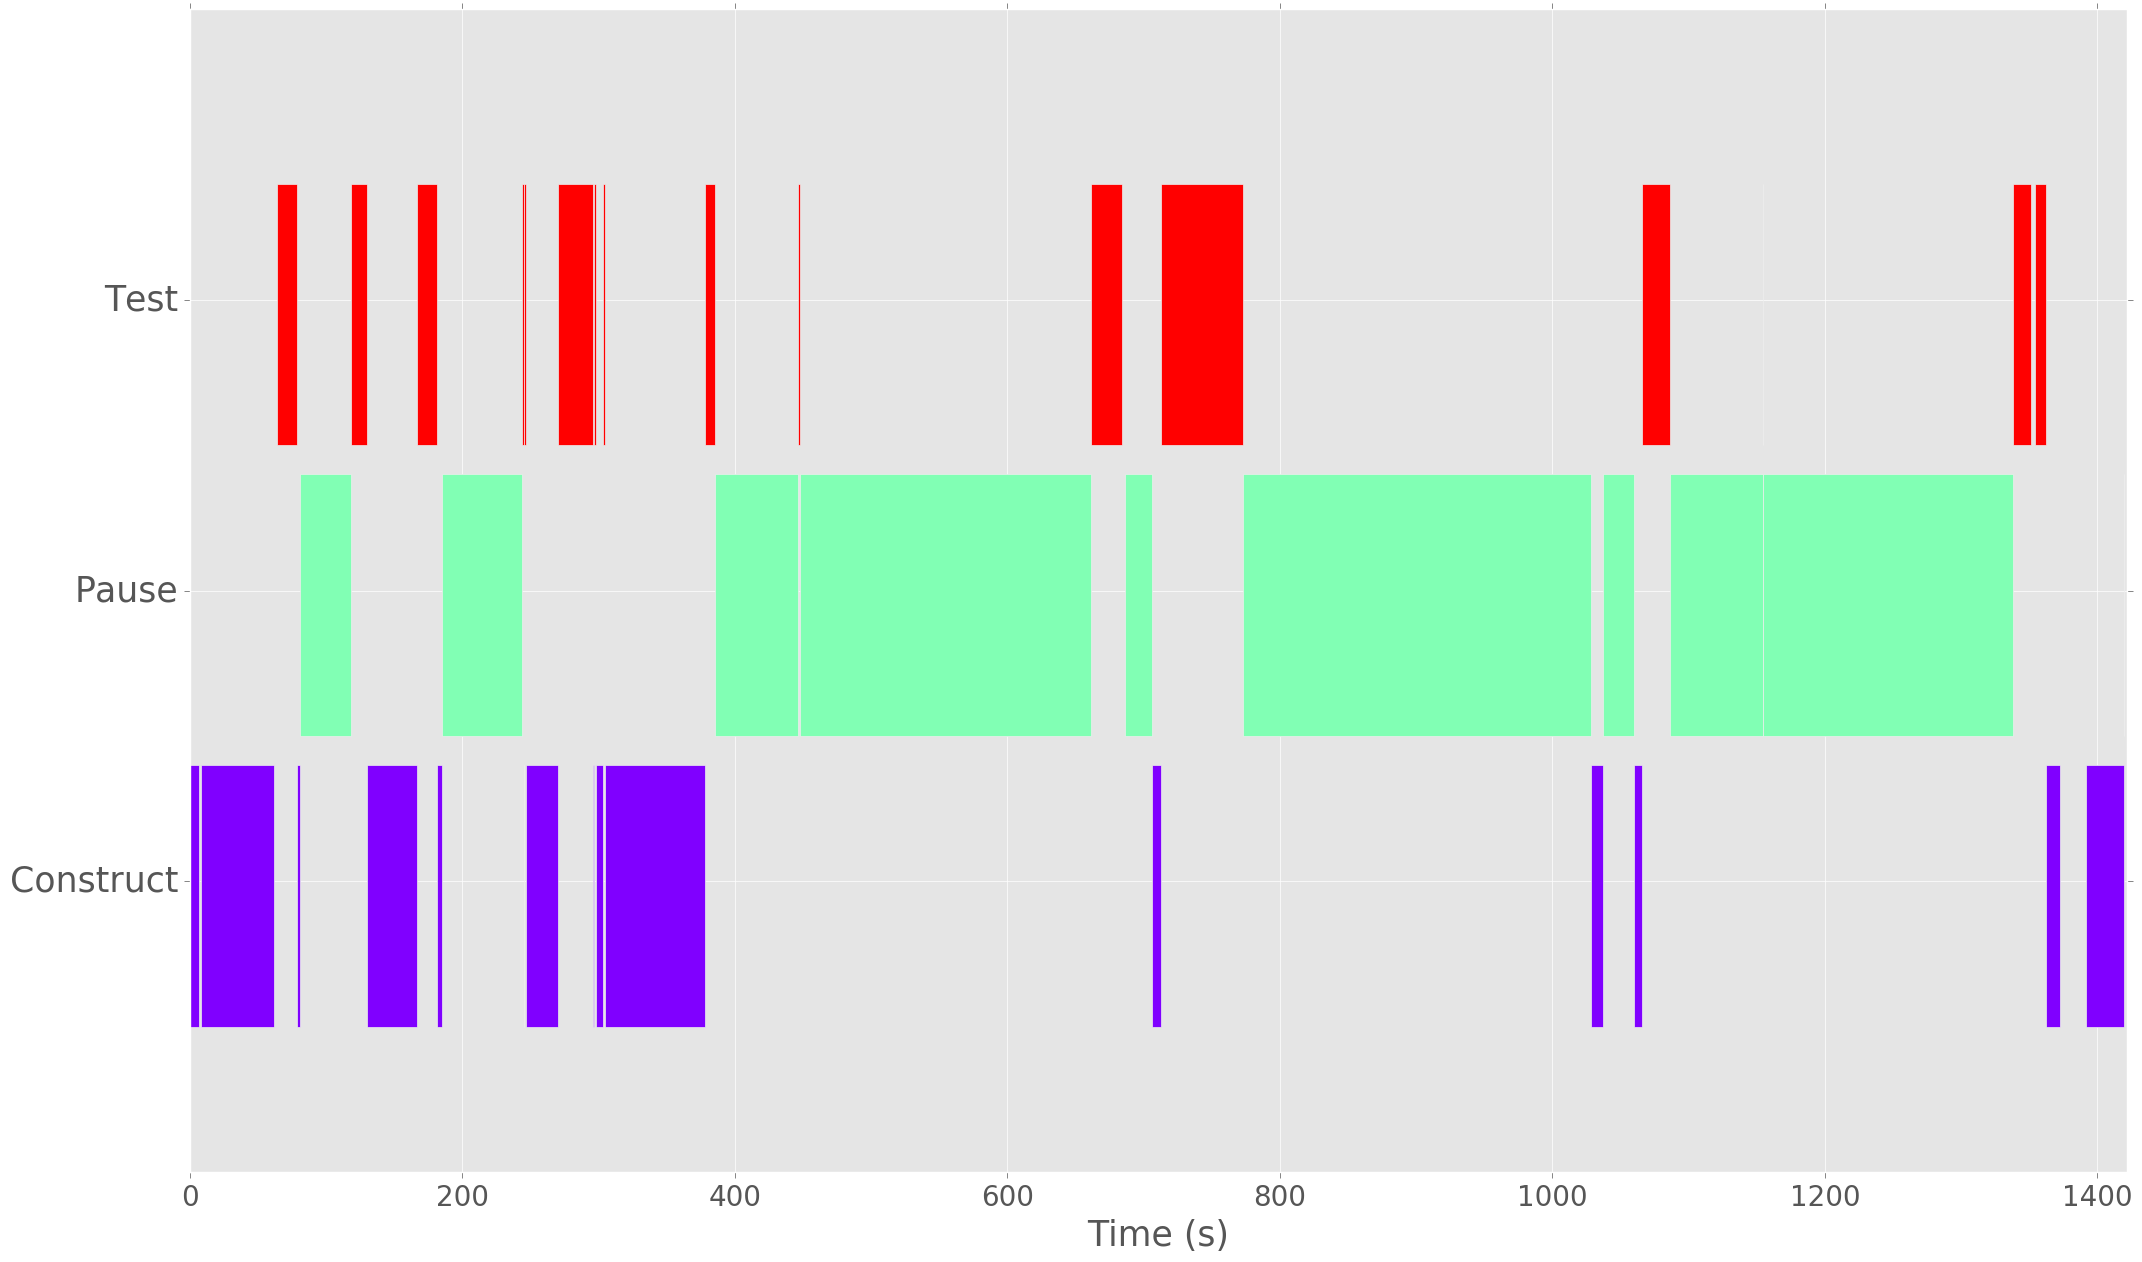

In [31]:
plot_barGraph(df2,'a2', 86170104, pltFamilies2) 

### High high

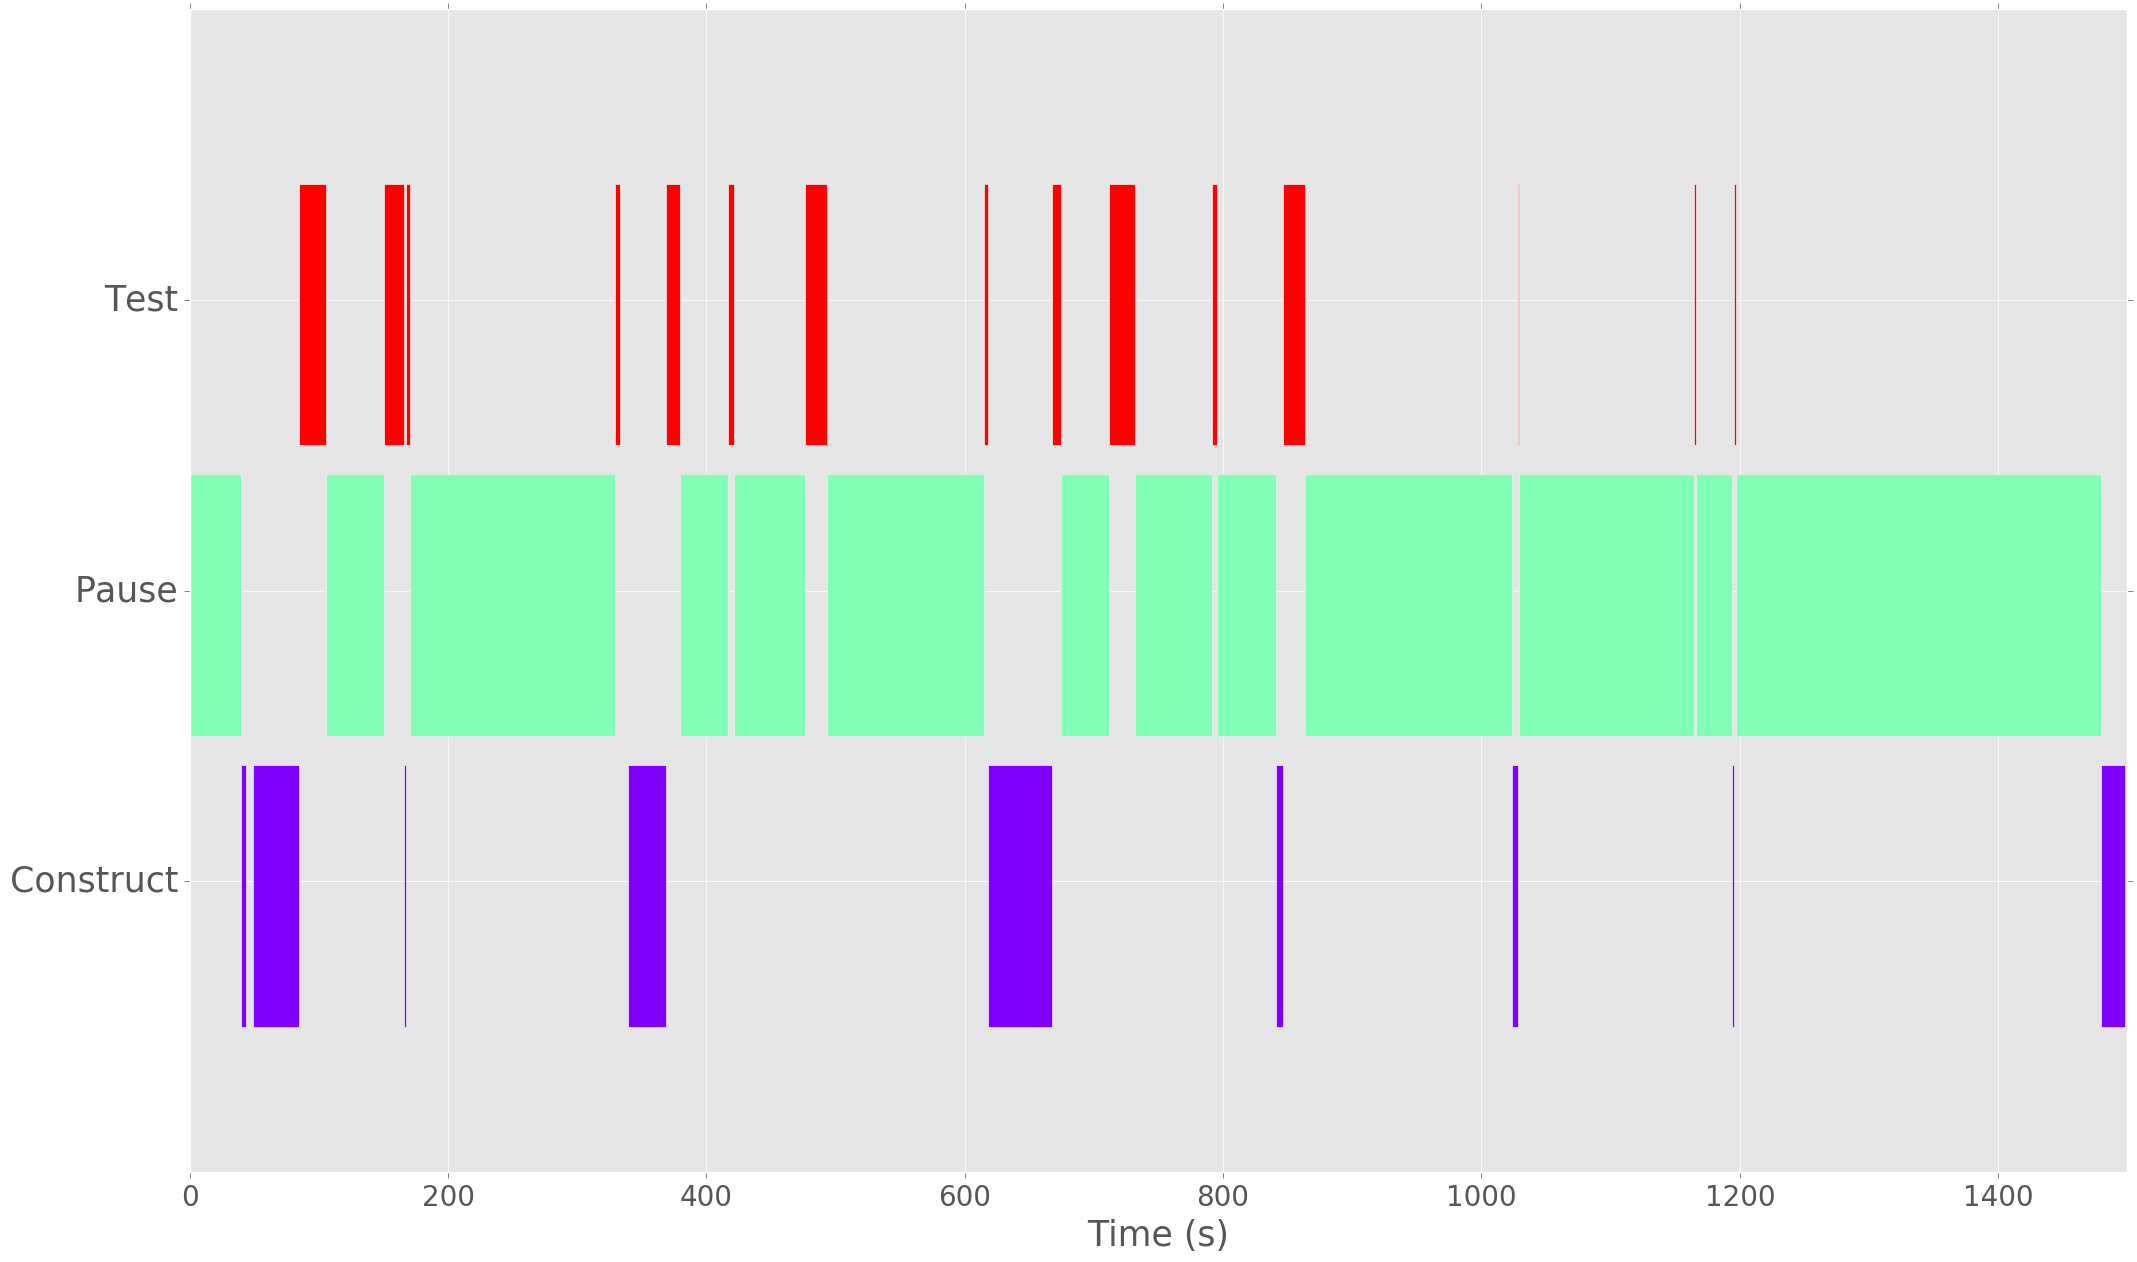

In [35]:
plot_barGraph(df2,'a2',8580120, pltFamilies2) #high high z-scores

### High to low

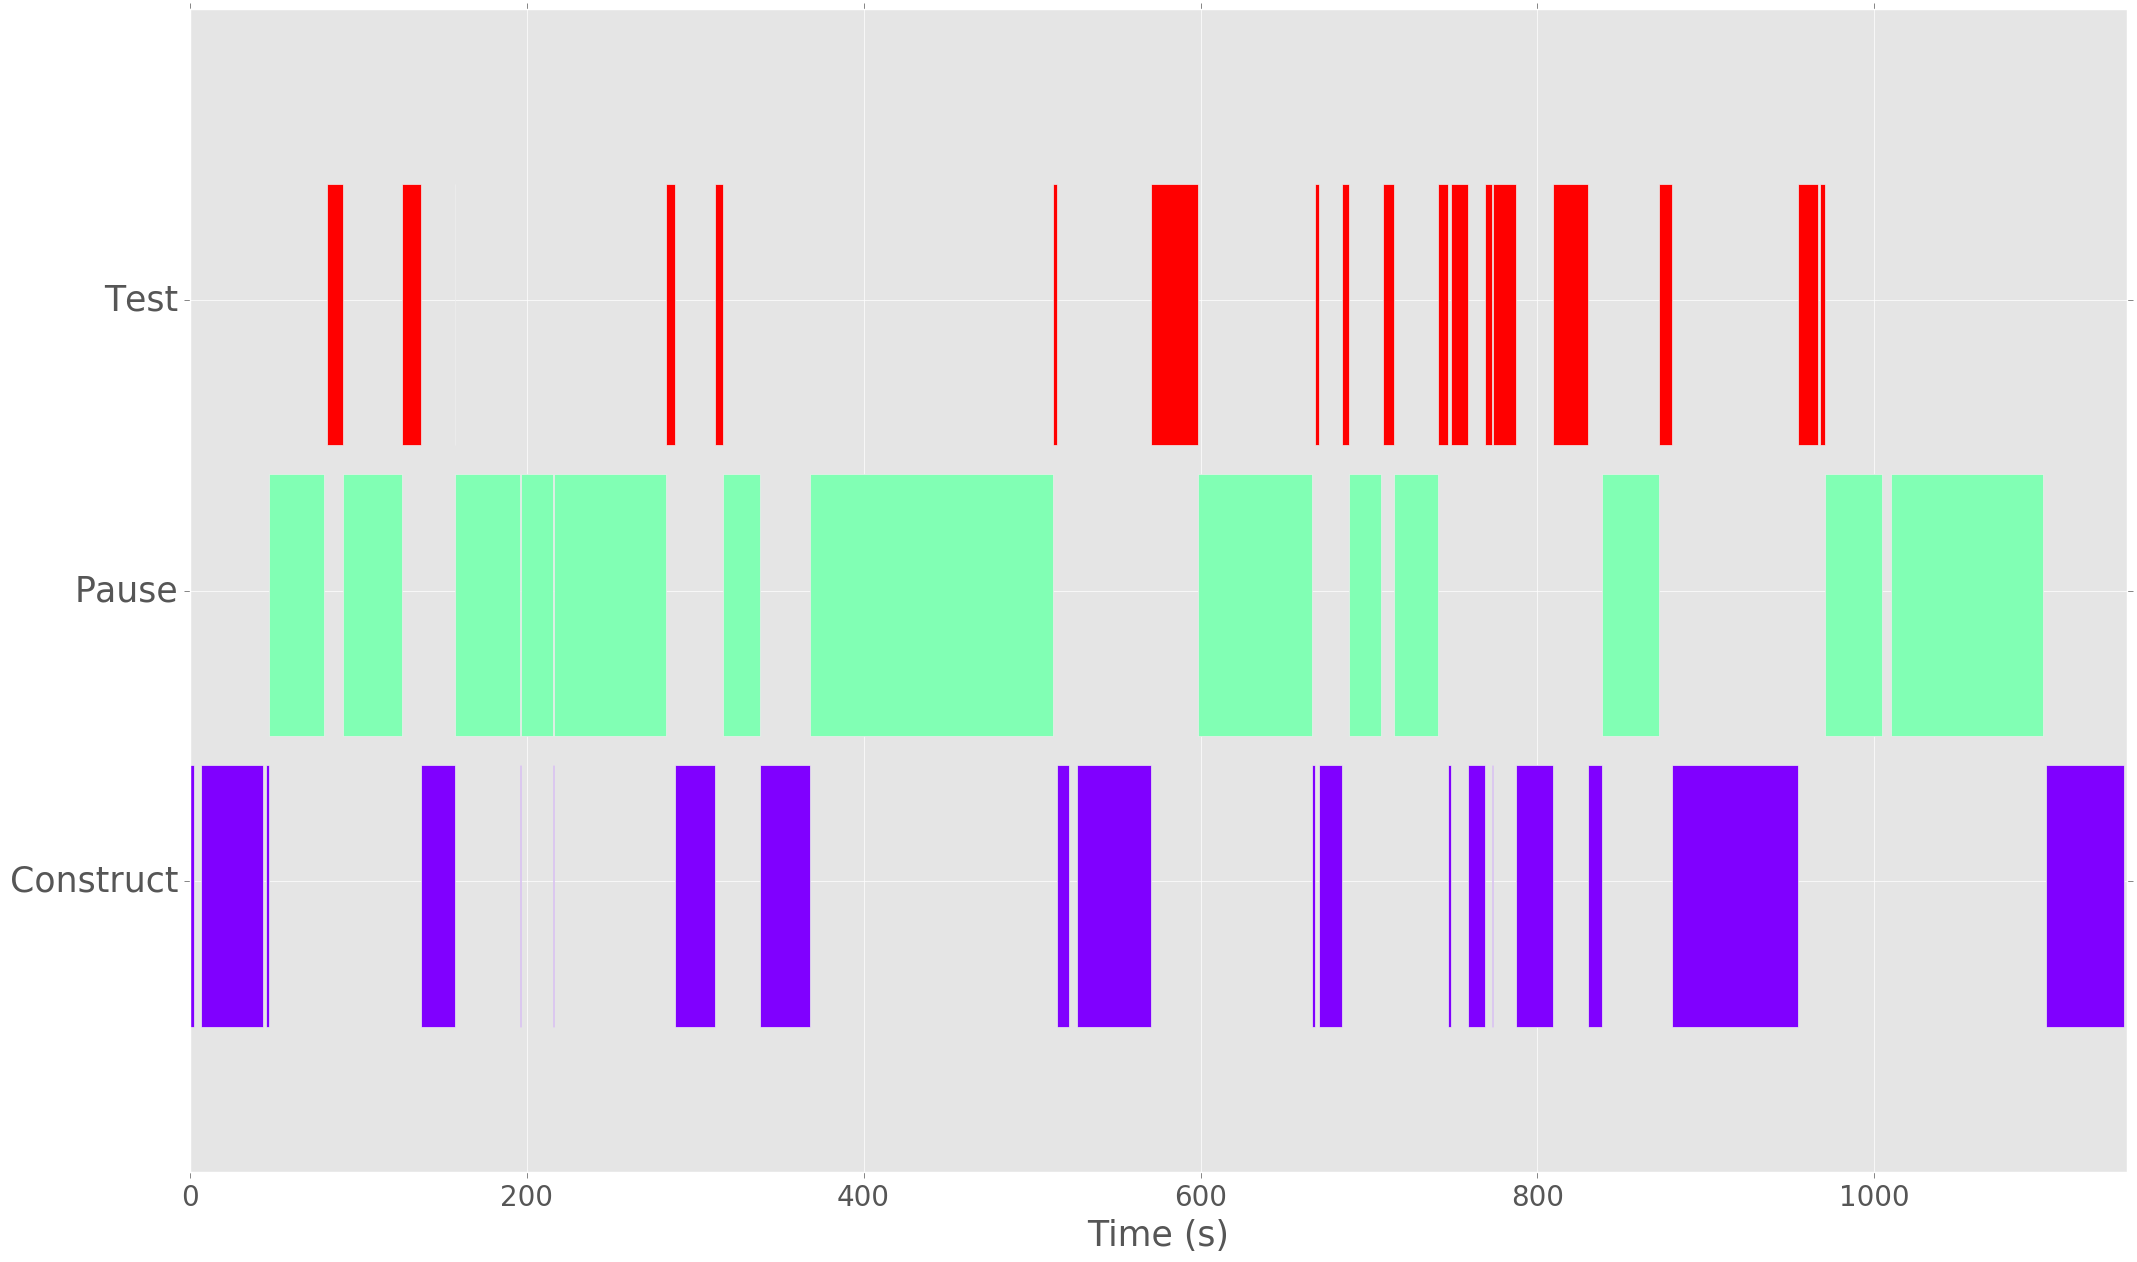

In [36]:
plot_barGraph(df2,'a2',31091114, pltFamilies2) #high low z-scores

### Low to low

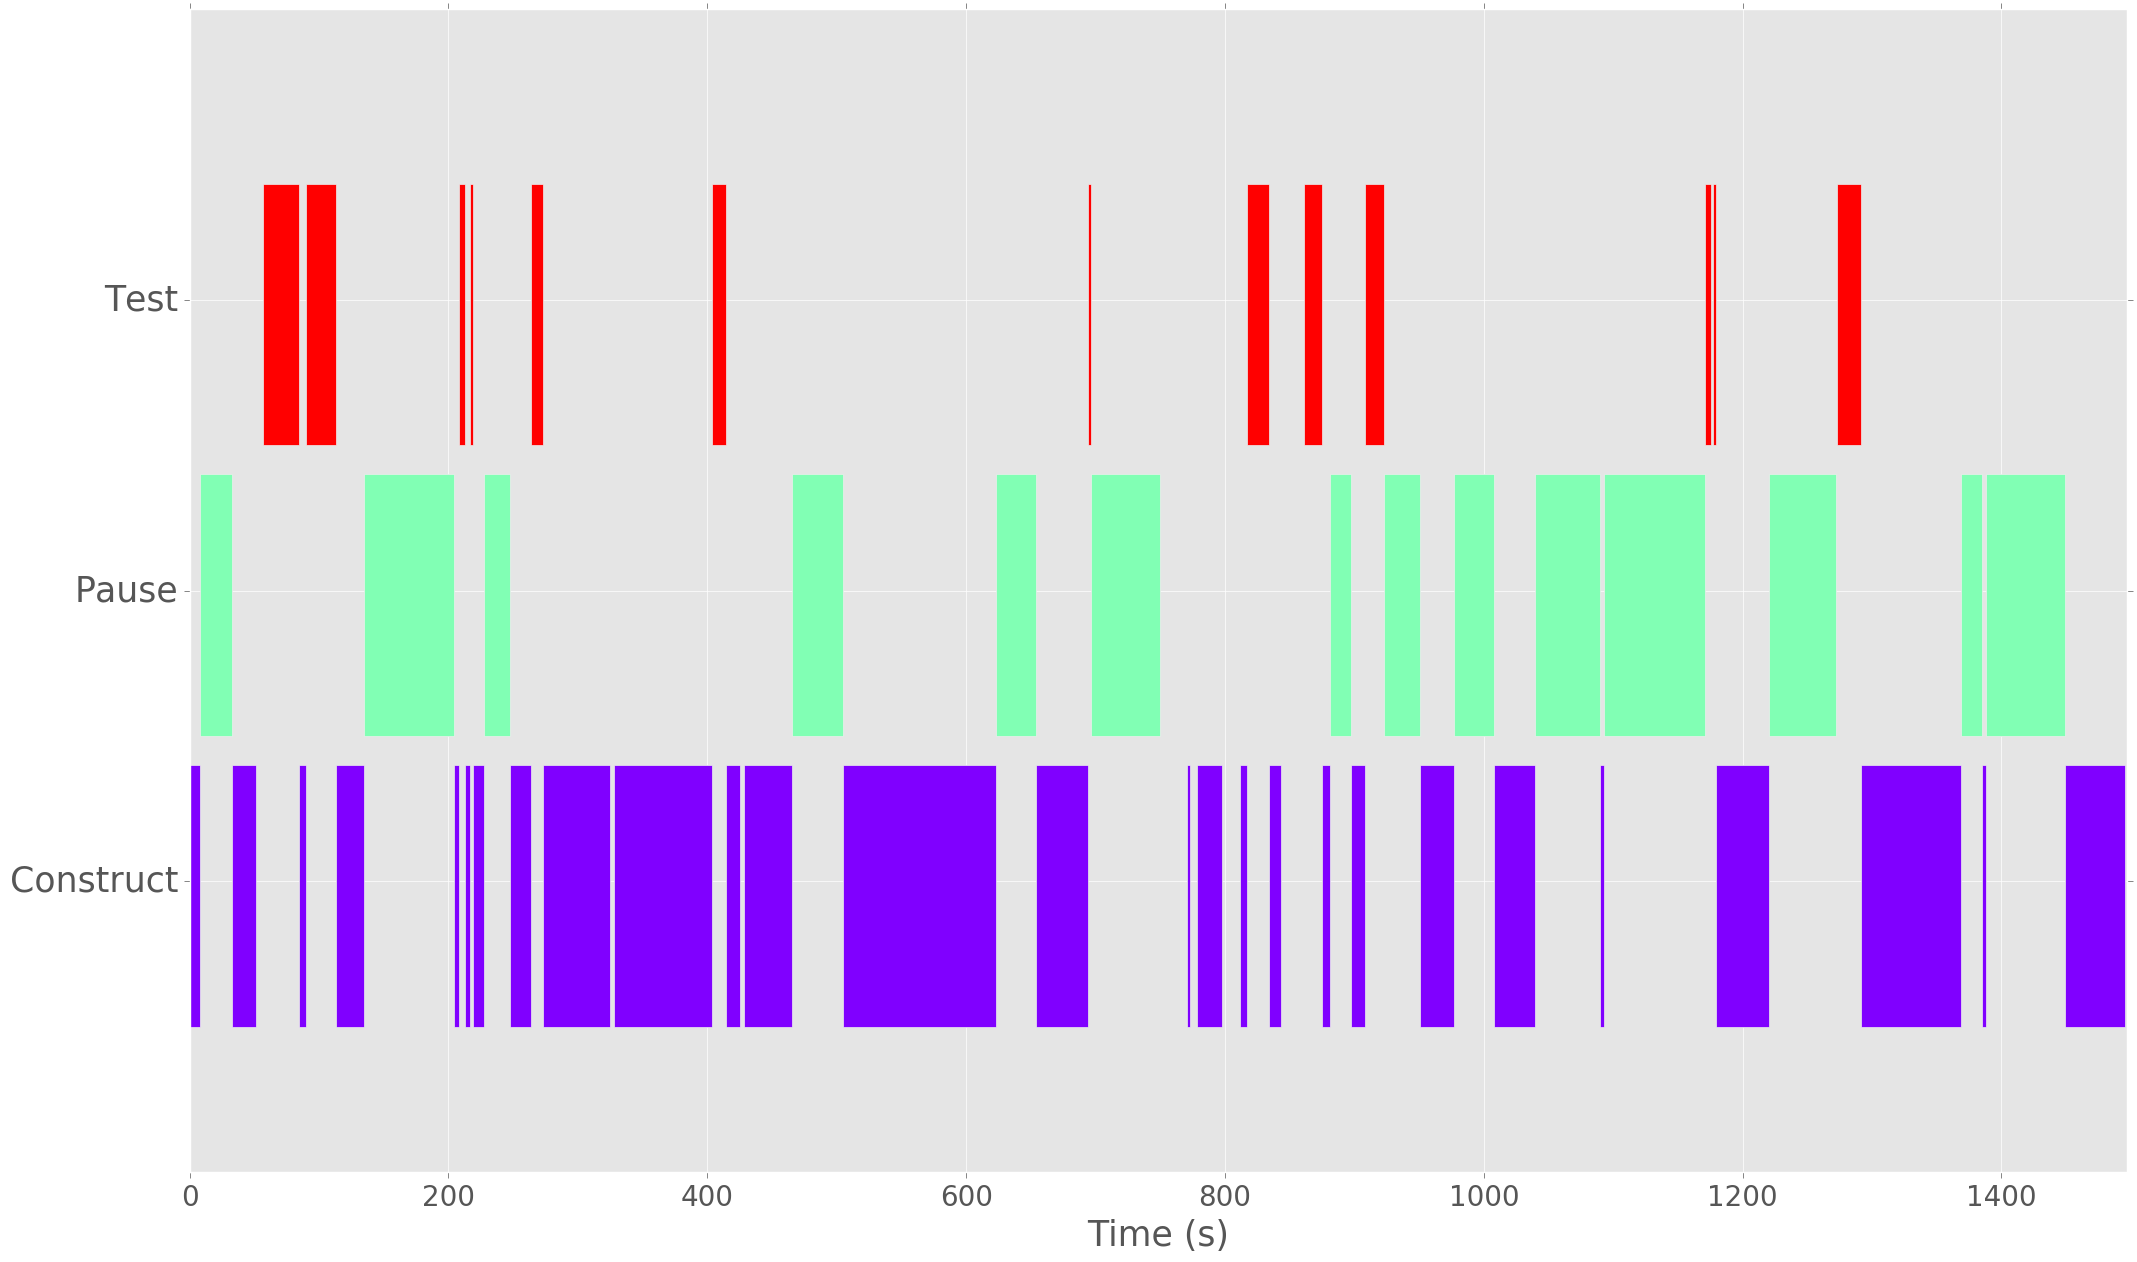

In [37]:
plot_barGraph(df2,'a2',8889108, pltFamilies2) #low low z-scores